##  **Часть 2. Ценовые А/B тесты. Формирование гипотез**


Помимо продуктовых А/B тестов на сайте [Utair.ru](https://www.utair.ru/ "Я ссылка") проводятся `ценовые тесты`. Их цель определить оптимульную цену на предоставляемые авиакомпанией [дополнительные услуги](https://www.utair.ru/support/6/chto_takoe_dopolnitelnie_uslugi "Я ссылка").

Перед проведением А/B теста необходимо определить `гипотезы`, которые подвергнуться проверке.

Гипотезы можно сформулировать двумя способами:
* на основании интуитивного предположения (например, логично, что чем больше дальность полета, тем выше вероятность того, что пассажир приобретет услугу "Выбор места");
* исследуя данные, выявляя закономерности и корреляцию между признаками. 

Вo второй части дипломного проекта будет проведен анализ данных по продажам дополнительных услуг ПАО "Авиакомпании Ютэйр" за период с 1 января 2021 года по 31 мая 2021 года с целью выявления направлений повышения выручки и формирования гипотез для проверки с помощью А/B теста.

`Перечень инструментов`, используемых в работе: 
* Python 3 для сбора и анализа данных;
* Jupyter как среда для написания скриптов;
* SQL для работы с базами данных;
* база данных SalesUT (SQL Server) как источник данных.



<p align="center">

  <img width="800" height="450" src="https://www.seobility.net/en/wiki/images/2/24/AB-Testing.png">

</p> 

### 1. Импортирование библиотек

In [1]:
# библиотека для подключения к БД
import pyodbc
# библиотеки для работы с данными
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
# библиотеки для статистического анализа
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# библиотеки для визуализации
import altair as alt
# отключение ограничения в 5000 строк для alt
alt.data_transformers.disable_max_rows()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# опции для вывода данных в нужном количестве и формате
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.0f}'.format)

### 2. Функции, используемые для подключения и обработки данных

In [2]:
def connection_sale():
    
    """Функция используется для подключения к БД """
    
	connection = pyodbc.connect(
		"Driver={SQL Server Native Client 11.0};"
	    "Server=XXXXXXXXXX;"
        "Database=XXXXXXXXXX;"
        "Trusted_Connection=yes;"
        "UID=XXXXXXXXXX;"
        "PWD=XXXXXXXXXX;"
	)
	print("Подключение к SalesUT установлено")
	return connection

def query_sale(connection, query):
    
     """Функция используется для выполнения запросов к БД """
        
	cursor = connection.cursor()
	result = pd.read_sql(query, connection)
	print("Запрос выполнен")
	return result

def description_column(x):
    
    """Функция используется для описания 
     столбца текстового типа """
    
    print('Количество уникальных значений в столбце:',x.nunique())
    print('Перечень уникальных значений:', x.unique())
    print('Длина столбца:',len(x))
    print('Количество значений "NaN":', x.isna().sum())
    print("Количество значений, встретившихся в столбце более 10 раз:", (x.value_counts()>10).sum())

def description_column_count(x):
    
    """Функция используется для описания 
     столбца числового типа """
    
    print('Длина столбца:',len(x))
    print('Количество значений "NaN":', x.isna().sum())
    print('Минимальное значение:', x.min())
    print('Максимальное значение:',x.max())  
    
def outliers(x): 
    
    """Функция используется для 
    определения границ выбросов"""
    
    median = x.median()
    IQR = x.quantile(0.75)-x.quantile(0.25)
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    print('25-й квартиль: {},'.format(q25), '75-й квартиль: {},'.format(q75), 'IQR: {},'.format(IQR),
     "границы выбросов: [{x_min},{x_max}].".format(x_min = q25-1.5*IQR, x_max = q75+1.5*IQR))

def delete_outliers(x): 
    
    """Функция используется для 
    очистки данных от выбросов"""
    
    median = x.median()
    IQR = x.quantile(0.75)-x.quantile(0.25)
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    x_min =q25-1.5*IQR
    x_max =q75+1.5*IQR
    return x_min, x_max
    
def boxplot(x1,y1,d,t,tx,ty):
    
    """Функция используется для 
    вывода boxplot"""
    
    red_square = dict(markerfacecolor='k', marker='s')
    plt.figure(figsize=(18, 5))
    plt.style.use('seaborn')
    sns.boxplot(x=x1, y=y1, data=d, linewidth=1, flierprops=red_square)
    plt.title(t, fontsize=15, color='black')
    plt.xlabel(tx, fontsize=15, color='black')
    plt.ylabel(ty, fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.grid(True)
    

def one_boxplot(x, title, x_title):
    
     """Функция используется для 
    вывода boxplot по одному признаку"""
        
    red_square = dict(markerfacecolor='k', marker='s')
    plt.figure(figsize=(18, 5))
    plt.style.use('seaborn')
    plt.tick_params(axis='both', labelsize=15)
    ax=sns.boxplot(x, linewidth=1, flierprops=red_square)
    ax.set_title(title, fontsize=15, color='black')
    ax.set_xlabel(x_title, fontsize=15, color='black')

def correlation(x,y):
    
    """Функция используется для 
    расчета коэффициента корреляции""" 
        
    display(pd.DataFrame(df_corr[[x,y]].corr()))

def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], 
                        df.loc[data.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

def cm_to_inch(value):
    return value/2.54

def bar_pivot_table(x,z,y,c,t,xl,yl):
    
    """Функция используется для 
    вывода диаграммы по нескольким признакам"""
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20,7)
    df_all.pivot_table(values = [x, z], index = [y], aggfunc = c).plot(kind = 'area',title = t)
    plt.xlabel(xl, fontsize=15, color='black')
    plt.ylabel(yl, fontsize=15, color='black')
    plt.title(t, fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(loc='lower right', facecolor='black', fontsize=15)
    plt.grid(False)
    plt.show()
    
def bar_pivot_table_(x,y,c,t,xl,yl):
    
    """Функция используется для 
    вывода диаграммы по одному признаку"""
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20,7)
    df_all.pivot_table(values = [x], index = [y], aggfunc = c).plot(kind = 'bar',title = t)
    plt.xlabel(xl, fontsize=15, color='black')
    plt.ylabel(yl, fontsize=15, color='black')
    plt.title(t, fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.legend(loc='upper right', facecolor='black', fontsize=15)
    plt.grid(False)
    plt.show()

def area_two_pivot_table(x,z,y,c,t,xl,yl):
    
    """Функция используется для 
    вывода диаграммы по одному признаку"""
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20,7)
    df_all.pivot_table(values = [x], index = [y], columns=[z], aggfunc = c).plot(kind = 'area',stacked=True,title = t)
    plt.xlabel(xl, fontsize=15, color='black')
    plt.ylabel(yl, fontsize=15, color='black')
    plt.legend()
    plt.grid(False)
    plt.show()
    
def share(x, x_name, y_name, title):
    
    """Функция используется для 
    вывода диаграммы по долям"""
    
    new=pd.DataFrame(x.value_counts(normalize = True)*100).reset_index(level=0).head(10).sort_values(by=['index'])
    new.columns=([x_name, y_name])
    plt.style.use('seaborn')
    plt.figure(figsize=(18, 5))
    plt.tick_params(axis='both', labelsize=15)
    ax=sns.barplot(x=x_name, y=y_name, data=new)   
    ax.set_ylabel(y_name, fontsize=15, color='black')
    ax.set_xlabel(x_name, fontsize=15, color='black')
    ax.set_title(title, fontsize=15, color='black')
    for counter, value in enumerate(new[y_name]):
        ax.text(counter, value, round(value), ha='left', size=16)


def share_count(x, x_name, y_name, title):
    
    """Функция используется для 
    вывода диаграммы по кол-ву"""
    
    new=pd.DataFrame(x.value_counts()).reset_index(level=0).head(10)
    new.columns=([x_name, y_name])
    plt.style.use('seaborn')
    plt.figure(figsize=(18, 5))
    plt.tick_params(axis='both', labelsize=15)
    ax=sns.barplot(x=x_name, y=y_name, data=new)
    ax.set_ylabel(y_name, fontsize=15, color='black')
    ax.set_xlabel(x_name, fontsize=15, color='black')
    ax.set_title(title, fontsize=15, color='black')
    for counter, value in enumerate(new[y_name]):
        ax.text(counter, value, round(value), ha='center', size=16)

def bar_groupby(x,y,z,t,xl,yl):
    
    """Функция используется для 
    вывода диаграммы по нескольким признакам"""
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20,7)
    df.groupby(by=[x,y])[z].value_counts(normalize=True).plot(kind='bar', title=t)
    plt.xlabel(xl, fontsize=15, color='black')
    plt.ylabel(yl, fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.grid(True)
    plt.show()

def hist(x):
    plt.style.use('seaborn')
    plt.tick_params(axis='both', labelsize=15)
    plt.hist(x)
    
def correlation_vis(x,y, title, x_label, y_label):
    
    """Функция используется для 
    вывода корреляционной матрицы"""
    
    plt.style.use('seaborn')
    col = [x, y]
    ax = sns.heatmap(df_corr[col].corr(), annot=True, cmap='RdYlGn', center=0, fmt='.2g', vmin=-1,
                     xticklabels=[x_label, y_label], yticklabels=[x_label, y_label])
    i, k = ax.get_ylim()
    ax.set_ylim(i+0.5, k-0.5)
    plt.title(title, fontsize=15, color='black')
    plt.xticks(fontsize=15, color='black')
    plt.yticks(fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.show()

def altair_bar(data, x_name, y_name, legend_name, title_name):
    
    """Функция используется для вывода диаграммы"""
    
    bar = alt.Chart(data,title=title_name).mark_bar(size=100).encode(
    x=alt.X(x_name, axis=alt.Axis(title=x_name, labelFontSize=13, titleFontSize=13, labelAngle=360)),
    y=alt.Y(y_name, axis=alt.Axis(title=y_name, labelFontSize=13, titleFontSize=13)),
    text=y_name,
    color=alt.value("SteelBlue"),
    size=alt.value(13))
    text = bar.mark_text(
    align='center',
    baseline='middle',
    angle=0,
    dy=-5).encode(
    text=alt.Text(y_name, format="s"),
    color=alt.value("black"))
    
    return (bar + text).properties(height=250, width=840)

def altair_bar_share(data, x_name, y_name, title_name):
    
    """Функция используется для вывода диаграммы по долям"""
    
    new=pd.DataFrame(data.value_counts(normalize = True)).reset_index(level=0).head(10)
    new.columns=([x_name, y_name])
    bar = alt.Chart(new, title=title_name).mark_bar(orient='horizontal').encode(
    y=alt.Y(x_name, axis=alt.Axis(title=x_name, labelFontSize=13, titleFontSize=13)),
    x=alt.X(y_name, axis=alt.Axis(title=y_name, format='%', labelFontSize=13, titleFontSize=13)),
    text=y_name,
    color=alt.value("SteelBlue"),
    size=alt.value(13))

    text = bar.mark_text(
    align='center',
    baseline='middle',
    angle=0,
    dx=40).encode(
    text=alt.Text(y_name, format="p"),
    color=alt.value("black"))
    
    return (bar + text).properties(height=250, width=820)

def hist(data, x1, x2, ylabel, xlabel, title):
    bins = np.arange(0, x1, x2)
    plt.style.use('seaborn')
    _, ax = plt.subplots(figsize=(18, 5))
    plt.tick_params(axis='both', labelsize=15)
    ax.hist(data, bins = bins)
    ax.set_ylabel(ylabel, fontsize=15, color='black')
    ax.set_xlabel(xlabel, fontsize=15, color='black')
    ax.set_title(title, fontsize=15, color='black')
    
def penet(x, y, i, p, title):
    
    """Функция используется для расчета пенетрации"""
    
    rout_group=df_all.pivot_table(values = [x, y], index = [i], aggfunc = sum)
    rout_group[p]=rout_group[y]/rout_group[x]*100
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (20,7)
    ax=rout_group.groupby(by=[i])[p].sum().plot(kind='bar')
    plt.xlabel(i, fontsize=15, color='black')
    plt.ylabel(p, fontsize=15, color='black')
    plt.title(title, fontsize=15, color='black')
    plt.tick_params(axis='both', labelsize=15)
    plt.grid(True)
    for counter, value in enumerate(rout_group[p]):
        ax.text(counter, value, round(value), ha='left', size=16)
    plt.show()

### 3. Объект исследования, сбор данных

#### 3.1. Определение объекта исследования

In [3]:
query_all_add = """
select d.[Группа услуг],
       SUM(d.[Количество проданных сегментов]) as [Количество услуг],
       SUM(d.[Выручка за вычетом бонусов]) as [Выручка за вычетом бонусов]
from
(select 
       dv.[Дата транзакции],
       dv.[Вид тарифа],
       dv.[Номер бланка],
       dv.[Номер купона],
       dv.[Вид операции (бланка)],
       dv.[Причина выписки купона EMD],
       dv.[Количество проданных сегментов],
       dv.[Класс бронирования],
case 
--до 25.03.2020 страховка 70%
    when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and [Дата транзакции]<=CONVERT(varchar,'25.03.2020',104))
	then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])*0.7
--c 26.03.2020 до 29.03.2020 64%
	when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and ([Дата транзакции]>=CONVERT(varchar,'26.03.2020',104) and [Дата транзакции]<=CONVERT(varchar,'29.03.2020',104)))
	then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])*0.64
--c 30.03.2020 до 29.04.2020 52%
	when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and ([Дата транзакции]>=CONVERT(varchar,'30.03.2020',104) and [Дата транзакции]<=CONVERT(varchar,'29.04.2020',104)))
	then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])*0.52
--c 30.04.2020 до 14.07.2020 52%
	when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and ([Дата транзакции]>=CONVERT(varchar,'30.04.2020',104) and [Дата транзакции]<=CONVERT(varchar,'14.07.2020',104))) 
	then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])*0.55	
--c 15.07.2020 70%
	when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and [Дата транзакции]>=CONVERT(varchar,'15.07.2020',104))
	then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])*0.7	
	else ((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])- dv.[Сумма бонусов на купоне (эквив. РУБ)])
end as [Выручка за вычетом бонусов],
case
  	when dv.[Вид тарифа] LIKE '%FL%' 
	     and SUBSTRING(dv.[Вид тарифа],1,3) IN ('J','C','A','Z','I')
          and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Business'               
	when dv.[Вид тарифа] LIKE '%FL%' 
	     and SUBSTRING(dv.[Вид тарифа],1,1) IN ('J','D','C','A','Z','I') 
          and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104) and dv.[Дата транзакции] <= CONVERT(varchar,'19.12.2018',104)) then 'Business'                 
     when dv.[Вид тарифа] LIKE '%FL%' 
	     and SUBSTRING(dv.[Вид тарифа],1,1) IN ('J','D','C','A','I')
          and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104))  THEN 'Business' 
	when dv.[Вид тарифа] LIKE '%COMF%'
          and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104))THEN 'Comfort' 			  
	when dv.[Вид тарифа] LIKE '%LT%' 
	     and  dv.[Вид тарифа] not LIKE '%SA%' 
		and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Light'
	when (dv.[Вид тарифа] LIKE '%STD%' OR dv.[Вид тарифа] LIKE '%ST%' or dv.[Вид тарифа] LIKE '%SS%') 
          and  dv.[Вид тарифа] NOT LIKE '%SA%' 
          and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Standart'			 
	when dv.[Вид тарифа] LIKE '%FL%'
          and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Flexible'
	when dv.[Вид тарифа] LIKE '%LT%' 
	     and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104)) THEN 'Minimum' 			 
	when (dv.[Вид тарифа] LIKE '%STD%' OR dv.[Вид тарифа] LIKE '%STR%')
          and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104))THEN 'Optimum'			   
	when dv.[Вид тарифа] LIKE '%FL%' and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104)) THEN 'Premium'		
	when (dv.[Вид тарифа] LIKE '%WFF%') then 'Reward econom'
     when (dv.[Вид тарифа] LIKE '%ZFF%') then 'Reward business' 
     when dv.[Класс бронирования] = 'Q' then 'Служебники'
     when dv.[Класс бронирования] = 'I' then 'Служебники'
end as [Бренд],
case when dv.[Причина выписки купона EMD] in ('060','04E','042','04D','0BJ','061') then 'Апгрейд'
     when dv.[Причина выписки купона EMD] in ('0E5','0IJ','0CU','0CZ','03C','1AA','0GP','0IA','0C2','0AA','0C1','0F4','PLB','0C2','0C2','0G7','0BT','0BS','024','025','026','05X','05Y','021','03B','0MN','0PS',
	 '0C3','0GM','0FB','0FK','0DK','035','02T','0IG','0PZ','0H5','0EF','0ED','AMM','AMP','04U','04V','065','0LN','0E3','0MU','08A','08G','0L5','0MJ','0M6','0C5','0FN','027','0DG','0FM','0IK','0H5','0H9',
     '0EG','0EH','0KJ','0KK','0FV','0L1','0HV','0DC','0FY','0HR','0F0','0KN','0KO','0EE','0LZ','0HZ','0H0','0F5','0GD','0GH','0GQ','0GI','0OD','0OE','0NP','0N1', 
	 '052','0F8','0EC','0HY','0FQ','0EB','0HS','0HT','0EI','0NR','0NT','0NS','051','0DD','SCT','SC2','0GO','010','09U','K21','K22','K23', 'KGR' ) then 'Багаж'	 
	 when (dv.[Причина выписки купона EMD] = '0B5' and dv.[Тариф на купоне РУБ] < 499) then 'Выбор места'
	 when (dv.[Причина выписки купона EMD] = '0B5' and (dv.[Тариф на купоне РУБ] > 499 or dv.[Тариф на купоне РУБ] = 499)) then 'Выбор места'
     when dv.[Причина выписки купона EMD] in ('BAS','PRS','ST1','PFS', 'STA','STX','STW', 'CMF','STR', 'ATW', 'ATX', 'SPE','STS','ODD','Z1W') then 'Выбор места'
	 when dv.[Причина выписки купона EMD] in ('BR2','BR3','LH1','LH2','LH3', 'LH4','LH5','LH6', 'LH7','VG7','VG8','HL3','KS2','KD1','KD2','KD3','DS1','DS2','DS3','DS4','SN1','SN2','SN3','SN4','PN1',
     'PN2','PN3','PN4','CHL','CH1','CH3','SL3','BF1','BF2','BF3','SL1','SL2', 'LD1', 'LD2','LD3','LD4','VG1','VG2','VG3','PS1','PS2', 'HL1', 'HL2','KS1', 'KS2','SW1', 'SW2','SW3','ML2','ML1',
     'BF4','LD5','LD6', 'LD7','CH2','PN1','PN3','PN4', 'PN2','019', 'BF5','VG4', 'AL2','DL1','DL2','DL3', 'KL1', 'KL3', 'AL4', 'AL5', 'AL1','AL3','SW5', 'ML3','SW4','0LQ', 'NG1','NG2','KL2','BR1') then 'Питание'
     when dv.[Причина выписки купона EMD] in ('A/СГ','0BG') then 'Страхование'
	 when dv.[Причина выписки купона EMD] in ('0BX','0BH','0G6','03P','0L7','07Y','0BW','SPF','SA','0NJ','OGP','05Q','0CP','996','MS1','MS2','MS3','MS4') then 'Прочие доп.услуги'
     when dv.[Причина выписки купона EMD] in ('RFP','992','993','995','FNA','RNA','981','98J','990','997','ABC','SPE','98I','977','98F','USN') then 'Прочие платы'
	 else 'Нет данных'
end as [Группа услуг]
from SalesUT.dbo.data2020view dv
     where (dv.[Вид операции (бланка)] = 'MPD/EBT' or dv.[Вид операции (бланка)] = 'MPD/MCO')
     and (dv.[Дата транзакции]>=CONVERT(varchar,'01.09.2020',104) and dv.[Дата транзакции]<=CONVERT(varchar,'31.05.2021',104))
     and CHARINDEX('CHAR', dv.[Вид тарифа])=0
     and CHARINDEX('REG', dv.[Вид тарифа])=0
     and dv.[Перевозчик] = 'UT'
     and dv.[Участвует в обмене?]='No'
     and dv.[Причина выписки купона EMD] <> 'O6O'
     ) d
where d.[Бренд] <> 'Служебники'
group by d.[Группа услуг]
"""


In [4]:
all_add = pd.DataFrame(query_sale(connection_sale(), query_all_add))
all_add.head()

Подключение к SalesUT установлено
Запрос выполнен


,Группа услуг,Количество услуг,Выручка за вычетом бонусов
0,Апгрейд,9401,104744917
1,Багаж,290388,682087260
2,Выбор места,915596,412651303
3,Питание,352732,65175157
4,Прочие доп.услуги,2483,8460981


In [5]:
all_add['Выручка за вычетом бонусов']=all_add['Выручка за вычетом бонусов'].astype(int)

In [6]:
altair_bar(all_add, 'Группа услуг', 'Выручка за вычетом бонусов', 'Группа услуг', 
            'Распределение дополнительных услгу по выручке, руб.')

alt.LayerChart(...)

*ПАО "Авиакомпании Ютэйр" предлагает своим пассажирам приобрести следующие  [дополнительные услуги](https://www.utair.ru/support/6/chto_takoe_dopolnitelnie_uslugi "Я ссылка")*

**Объектом исследования** *в данной работе выступает услуга* **Выбор места**.

#### 3.2. Формирование dataframe для проведения исследования

In [7]:
query = """
Select  new.[PAS_Дата транзакции] as [Дата транзакции],
        new.[PAS_Дата вылета] as [Дата вылета],
        new.[PAS_PNR] as [PNR],
        new.[PAS_Маршрут] as [Маршрут],
		new.[PAS_Номер рейса] as [Номер рейса],
        new.[PAS_Канал] as [Канал],
		new.[Перевозка туда-обратно] as [Направление],
        new.[PAS_Minimum] as [Сегменты_минимум],
        new.[PAS_Optimum] as [Сегменты_оптимум],
        new.[PAS_Premium] as [Сегменты_премиум],
        new.[PAS_Business] as [Сегменты_бизнес],
        new.[PAS_Служебники] as [Сегменты_служебники],
        new.[PAS_Прочее] as [Сегменты_прочие],
        SUM(new.[PAS_Количество проданных сегментов]) as [Сегменты],
        SUM(new.[PAS_Выручка за вычетом бонусов]) as [Выручка],
        SUM(new.[PAS_Количество проданных сегментов взрослые]) as [Сегменты_взрослые],
        SUM(new.[PAS_Выручка за вычетом бонусов взрослые]) as [Выручка_взрослые],
        SUM(new.[PAS_Количество проданных сегментов дети]) as [Сегменты_дети],
        SUM(new.[PAS_Выручка за вычетом бонусов дети]) as [Выручка_дети],
        SUM(new.[PAS_Количество проданных сегментов младенцы]) as [Сегменты_младенцы],
        SUM(new.[PAS_Выручка за вычетом бонусов младенцы]) as [Выручка_младенцы],
        SUM(new.[Выбор места_количество]) as [Количество_ВМ],
        SUM(new.[Выбор места_выручка]) as [Выручка_ВМ],
        SUM(new.[Выбор места+_количество]) as [Количество_ВМ+],
        SUM(new.[Выбор места+_выручка]) as [Выручка_ВМ+]

from
(
Select m.*, c.*
from
/*Сбор данных по пассажирам*/
(
select b.[PAS_Дата транзакции],
        b.[PAS_Дата вылета],
        b.[PAS_PNR],
        b.[id],
        b.[PAS_Номер рейса],
        b.[PAS_Канал],
		b.[Перевозка туда-обратно],
		b.[PAS_Маршрут],
        case when b.[PAS_Бренд] = 'Minimum' then SUM(b.[PAS_Количество проданных сегментов]) else 0 end as [PAS_Minimum],
        case when b.[PAS_Бренд] = 'Optimum' then SUM(b.[PAS_Количество проданных сегментов]) else 0 end as [PAS_Optimum],
        case when b.[PAS_Бренд] = 'Premium' then SUM(b.[PAS_Количество проданных сегментов]) else 0 end as [PAS_Premium],
        case when b.[PAS_Бренд] = 'Business' then SUM(b.[PAS_Количество проданных сегментов]) else 0 end as [PAS_Business],
        case when b.[PAS_Бренд] = 'Служебники' then SUM(b.[PAS_Количество проданных сегментов]) else 0 end as [PAS_Служебники],
        case when b.[PAS_Бренд] = 'Прочие' then SUM(b.[PAS_Количество проданных сегментов]) else 0 end as [PAS_Прочее],
        SUM(b.[PAS_Количество проданных сегментов]) as [PAS_Количество проданных сегментов],
        SUM(b.[PAS_Выручка за вычетом бонусов]) as [PAS_Выручка за вычетом бонусов],
        SUM(b.[PAS_Количество проданных сегментов дети]) as [PAS_Количество проданных сегментов дети],
        SUM(b.[PAS_Количество проданных сегментов младенцы]) as [PAS_Количество проданных сегментов младенцы],
        SUM(b.[PAS_Количество проданных сегментов взрослые]) as [PAS_Количество проданных сегментов взрослые],
        SUM(b.[PAS_Выручка за вычетом бонусов дети]) as [PAS_Выручка за вычетом бонусов дети],
        SUM(b.[PAS_Выручка за вычетом бонусов младенцы]) as [PAS_Выручка за вычетом бонусов младенцы],
        SUM(b.[PAS_Выручка за вычетом бонусов взрослые]) as [PAS_Выручка за вычетом бонусов взрослые]
from
(
select dv.[Дата транзакции] as [PAS_Дата транзакции],
       dv.[Дата вылета] as [PAS_Дата вылета],
       dv.[Вид тарифа] as [PAS_Вид тарифа],
       dv.[Номер бланка] as [PAS_Номер бланка],
       dv.[Номер купона] as [PAS_Номер купона],
	   /*id для связи пассажиров с дополнительными услугами*/
	   concat(dv.[PNR],'-',dv.[Номер рейса]) as [id],
       dv.[Номер рейса] as [PAS_Номер рейса],
       dv.[Пункт вылета] as [PAS_Пункт вылета],
       dv.[Пункт прилета] as [PAS_Пункт прилета],
       dv.[Код агента] as [PAS_Код агента],
       dv.[Вид операции (бланка)] as [PAS_Вид операции (бланка)],
       dv.[PNR] as [PAS_PNR],
       dv.[Количество купонов документа] as [PAS_Количество купонов документа],
       dv.[Количество проданных сегментов] as [PAS_Количество проданных сегментов],
      ((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ])) as [PAS_Выручка за вычетом бонусов],
       dv.[Категория пассажира],
	   dv.[Перевозка туда-обратно],
	   /*Количество детей, младенцев, взрослых*/
       case when dv.[Категория пассажира] in ('CHILD')
            then dv.[Количество проданных сегментов]
       end as [PAS_Количество проданных сегментов дети],
	   case when dv.[Категория пассажира] in ('INFANTSEAT','INFANT')
            then dv.[Количество проданных сегментов]
       end as [PAS_Количество проданных сегментов младенцы],
       case when dv.[Категория пассажира] = 'ADULT'
            then dv.[Количество проданных сегментов]
       end as [PAS_Количество проданных сегментов взрослые],
	   /*Выручка по детям, младенцам, взрослым*/
       case when dv.[Категория пассажира] in ('CHILD')
            then ((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ]))
       end as [PAS_Выручка за вычетом бонусов дети],
       case when dv.[Категория пассажира] in ('INFANTSEAT','INFANT')
            then ((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ]))
       end as [PAS_Выручка за вычетом бонусов младенцы],
       case when dv.[Категория пассажира] = 'ADULT'
            then ((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ]))
       end as [PAS_Выручка за вычетом бонусов взрослые],
      /*Определение канала*/
	  case when dv.[Код агента] = '02ТЮМ' or dv.[Код агента] = '865' 
           then 'Онлайн' 
	       else 'Оффлайн'
      end as [PAS_Канал],
	  /*Корректировка кодов аэропортов*/
      case when dv.[Пункт вылета] = 'BER' then 'TXL'
           when dv.[Пункт вылета] = 'BAK' then 'GYD'
	       when dv.[Пункт вылета] = 'ULY' then 'ULV'
	       when dv.[Пункт вылета] = 'MOW' then 'VKO'
	       when dv.[Пункт вылета] = 'MXP' then 'MIL'
	       else dv.[Пункт вылета]
      end as [PAS_Пункт вылета верный],
     case when dv.[Пункт прилета] = 'BER' then 'TXL'
          when dv.[Пункт прилета] = 'BAK' then 'GYD'
	      when dv.[Пункт прилета] = 'ULY' then 'ULV'
	      when dv.[Пункт прилета] = 'MOW' then 'VKO'
	      when dv.[Пункт прилета] = 'MXP' then 'MIL'
	      else dv.[Пункт прилета]
     end as [PAS_Пункт прилета верный],
     case when dv.[Пункт вылета] < dv.[Пункт прилета] 
	      then concat(dv.[Пункт вылета],'-',dv.[Пункт прилета])
	      else concat(dv.[Пункт прилета],'-',dv.[Пункт вылета])
     end as [PAS_Маршрут],
    case
  	     WHEN dv.[Вид тарифа] LIKE '%FL%' 
	     and SUBSTRING(dv.[Вид тарифа],1,3) IN ('J','C','A','Z','I')
         and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Business'               
	     WHEN dv.[Вид тарифа] LIKE '%FL%' 
	     and SUBSTRING(dv.[Вид тарифа],1,1) IN ('J','D','C','A','Z','I') 
         and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104) and dv.[Дата транзакции] <= CONVERT(varchar,'19.12.2018',104)) THEN 'Business'                 
         WHEN dv.[Вид тарифа] LIKE '%FL%' 
	     and SUBSTRING(dv.[Вид тарифа],1,1) IN ('J','D','C','A','I')
         and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104))  THEN 'Business' 
	     WHEN dv.[Вид тарифа] LIKE '%COMF%'
         and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104))THEN 'Comfort' 			  
	     when dv.[Вид тарифа] LIKE '%LT%' 
	     and  dv.[Вид тарифа] not LIKE '%SA%' 
		 and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Light'
	     when (dv.[Вид тарифа] LIKE '%STD%' OR dv.[Вид тарифа] LIKE '%ST%' or dv.[Вид тарифа] LIKE '%SS%') 
         and  dv.[Вид тарифа] NOT LIKE '%SA%' 
         and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Standart'			 
	     WHEN dv.[Вид тарифа] LIKE '%FL%'
         and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Flexible'
	     when dv.[Вид тарифа] LIKE '%LT%' 
	     and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104)) THEN 'Minimum' 			 
	     WHEN (dv.[Вид тарифа] LIKE '%STD%' OR dv.[Вид тарифа] LIKE '%STR%')
         and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104))THEN 'Optimum'			   
	     WHEN dv.[Вид тарифа] LIKE '%FL%' and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104)) THEN 'Premium'		
	     -- WHEN (dv.[Вид тарифа] LIKE '%WFF%') then 'Reward econom'
         -- when (dv.[Вид тарифа] LIKE '%ZFF%') then 'Reward business' 
         when dv.[Класс бронирования] = 'Q' then 'Служебники'
         when dv.[Класс бронирования] = 'I' then 'Служебники'
         else 'Прочие'
    end as [PAS_Бренд]
from SalesUT.dbo.data2020view dv
     where (dv.[Вид операции (бланка)] = 'TCT')
     and dv.[Дата транзакции]>=CONVERT(varchar,'01.09.2020',104)
     and CHARINDEX('CHAR', dv.[Вид тарифа])=0
     and CHARINDEX('REG', dv.[Вид тарифа])=0
     and dv.[Перевозчик] = 'UT'
     and dv.[Участвует в обмене?]='No'
) b
group by b.[PAS_Дата транзакции],
        b.[PAS_Дата вылета],
        b.[PAS_PNR],
        b.[id],
        b.[PAS_Номер рейса],
        b.[PAS_Канал],
        b.[PAS_Бренд],
		b.[Перевозка туда-обратно],
		b.[PAS_Маршрут]
) m
left join 
(
Select distinct pp.[id_add],
      SUM(pp.[Прочие платы_количество]) as [Прочие платы_количество],
      SUM(pp.[Прочие платы_выручка]) as [Прочие платы_выручка],
      SUM(pp.[Апгрейд_количество]) as [Апгрейд_количество],
      SUM(pp.[Апгрейд_выручка]) as [Апгрейд_выручка],
      SUM(pp.[Багаж_количество]) as [Багаж_количество],
      SUM(pp.[Багаж_выручка]) as [Багаж_выручка],
      SUM(pp.[Выбор места_количество]) as [Выбор места_количество],
      SUM(pp.[Выбор места_выручка]) as [Выбор места_выручка],
      SUM(pp.[Выбор места+_количество]) as [Выбор места+_количество],
      SUM(pp.[Выбор места+_выручка]) as [Выбор места+_выручка],
      SUM(pp.[Прочие доп.услуги_количество]) as [Прочие доп.услуги_количество],
      SUM(pp.[Прочие доп.услуги_выручка]) as [Прочие доп.услуги_выручка],
      SUM(pp.[Страхование_количество]) as [Страхование_количество],
      SUM(pp.[Страхование_выручка]) as [Страхование_выручка],
      SUM(pp.[Питание_количество]) as [Питание_количество],
      SUM(pp.[Питание_выручка]) as [Питание_выручка]
from
(
Select distinct p.[id_add],
      p.[ADD_Группа услуг],
     case when p.[ADD_Группа услуг] = 'Прочие платы'
	      then  SUM(p.[ADD_Количество проданных сегментов])
          else 0
     end as [Прочие платы_количество],
     case when p.[ADD_Группа услуг] = 'Прочие платы'
	      then  SUM(p.[ADD_Выручка за вычетом бонусов])
          else 0
     end as [Прочие платы_выручка],
     case when p.[ADD_Группа услуг] = 'Апгрейд'
	      then  SUM(p.[ADD_Количество проданных сегментов])
          else 0
     end as [Апгрейд_количество],
     case when p.[ADD_Группа услуг] = 'Апгрейд'
	      then  SUM(p.[ADD_Выручка за вычетом бонусов])
          else 0
     end as [Апгрейд_выручка],
     case when p.[ADD_Группа услуг] = 'Багаж'
	      then  SUM(p.[ADD_Количество проданных сегментов])
          else 0
     end as [Багаж_количество],
     case when p.[ADD_Группа услуг] = 'Багаж'
	      then  SUM(p.[ADD_Выручка за вычетом бонусов])
          else 0
     end as [Багаж_выручка],
     case when p.[ADD_Группа услуг] = 'Выбор места'
	      then  SUM(p.[ADD_Количество проданных сегментов])
          else 0
     end as [Выбор места_количество],
     case when p.[ADD_Группа услуг] = 'Выбор места'
	      then  SUM(p.[ADD_Выручка за вычетом бонусов])
          else 0
     end as [Выбор места_выручка],
     case when p.[ADD_Группа услуг] = 'Выбор места+'
	      then  SUM(p.[ADD_Количество проданных сегментов])
          else 0
     end as [Выбор места+_количество],
     case when p.[ADD_Группа услуг] = 'Выбор места+'
	      then  SUM(p.[ADD_Выручка за вычетом бонусов])
          else 0
     end as [Выбор места+_выручка],
     case when p.[ADD_Группа услуг] = 'Прочие доп.услуги'
	      then  SUM(p.[ADD_Количество проданных сегментов])
          else 0
     end as [Прочие доп.услуги_количество],
     case when p.[ADD_Группа услуг] = 'Прочие доп.услуги'
	      then  SUM(p.[ADD_Выручка за вычетом бонусов])
          else 0
     end as [Прочие доп.услуги_выручка],
     case when p.[ADD_Группа услуг] = 'Страхование'
	     then  SUM(p.[ADD_Количество проданных сегментов])
         else 0
     end as [Страхование_количество],
     case when p.[ADD_Группа услуг] = 'Страхование'
	      then  SUM(p.[ADD_Выручка за вычетом бонусов])
          else 0
     end as [Страхование_выручка],
     case when p.[ADD_Группа услуг] = 'Питание'
	      then  SUM(p.[ADD_Количество проданных сегментов])
          else 0
     end as [Питание_количество],
     case when p.[ADD_Группа услуг] = 'Питание'
	      then  SUM(p.[ADD_Выручка за вычетом бонусов])
          else 0
     end as [Питание_выручка]
 from
(
select dv.[Дата транзакции] as [ADD_Дата транзакции],
       dv.[Дата вылета] as [ADD_Дата вылета],
       dv.[Вид тарифа] as [ADD_Вид тарифа],
       dv.[Группа доп.услуг] as [ADD_Группа доп.услуг],
       dv.[Номер бланка] as [ADD_Номер бланка],
       dv.[Номер купона] as [ADD_Номер купона],
       dv.[Номер рейса] as [ADD_Номер рейса],
       dv.[Пункт вылета] as [ADD_Пункт вылета],
       dv.[Пункт прилета] as [ADD_Пункт прилета],
       dv.[Код агента] as [ADD_Код агента],
       dv.[Вид операции (бланка)] as [ADD_Вид операции (бланка)],
       dv.[Причина выписки купона EMD] as [ADD_Причина выписки купона EMD],
       dv.[PNR] as [ADD_PNR],
       dv.[EMD - связанный документ] as [ADD_EMD - связанный документ],
       dv.[EMD - номер купона связанного документа] as [ADD_EMD - номер купона связанного документа],
	   /*id для связи с пассажирами*/
	   concat(dv.[PNR],'-',dv.[Номер рейса]) as [id_add],
       dv.[Количество купонов документа] as [ADD_Количество купонов документа],
       dv.[Количество проданных сегментов] as [ADD_Количество проданных сегментов],
       dv.[Наименование агента] as [ADD_Наименование агента],
       dv.[Фактический агент BSP Russia] as [ADD_Фактический агент BSP Russia],
       /*Расчет выручки с учетом изменения доходной ставки услуги "Страхование"*/
     case 
    /*до 25.03.2020 страховка 70%*/
     when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and [Дата транзакции]<=CONVERT(varchar,'25.03.2020',104))
	 then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ]))*0.7
    /*c 26.03.2020 до 29.03.2020 64%*/
	 when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and ([Дата транзакции]>=CONVERT(varchar,'26.03.2020',104) and [Дата транзакции]<=CONVERT(varchar,'29.03.2020',104)))
	 then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ]))*0.64
    /*c 30.03.2020 до 29.04.2020 52%*/
	 when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and ([Дата транзакции]>=CONVERT(varchar,'30.03.2020',104) and [Дата транзакции]<=CONVERT(varchar,'29.04.2020',104)))
	 then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ]))*0.52
    /*c 30.04.2020 до 14.07.2020 52%*/
	 when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and ([Дата транзакции]>=CONVERT(varchar,'30.04.2020',104) and [Дата транзакции]<=CONVERT(varchar,'14.07.2020',104))) 
	 then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ]))*0.55	
    /*c 15.07.2020 70%*/
	 when (dv.[Причина выписки купона EMD] in ('A/СГ','0BG') and [Дата транзакции]>=CONVERT(varchar,'15.07.2020',104))
	 then((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ]))*0.7	
	 else ((dv.[Тариф на купоне РУБ]+ dv.[Топливный сбор РУБ]+ dv.[Штраф за возврат\обмен (CP) РУБ]+ dv.[Сбор RU РУБ]+ dv.[Сбор за бланк (PS,YR) РУБ]+ dv.[Прочие сборы РУБ]))
     end as [ADD_Выручка за вычетом бонусов],
     case when dv.[Код агента] = '02ТЮМ' or dv.[Код агента] = '865' 
          then 'Онлайн' 
	      else 'Оффлайн'
     end as [ADD_Канал],
     case when dv.[Наименование агента] in ('BSP Russia')
          then dv.[Фактический агент BSP Russia]
	      else dv.[Наименование агента]
     end as [ADD_Агент],
     case when dv.[Пункт вылета] = 'BER' then 'TXL'
          when dv.[Пункт вылета] = 'BAK' then 'GYD'
	      when dv.[Пункт вылета] = 'ULY' then 'ULV'
	      when dv.[Пункт вылета] = 'MOW' then 'VKO'
	      when dv.[Пункт вылета] = 'MXP' then 'MIL'
	      else dv.[Пункт вылета]
     end as [ADD_Пункт вылета верный],
     case when dv.[Пункт прилета] = 'BER' then 'TXL'
          when dv.[Пункт прилета] = 'BAK' then 'GYD'
	      when dv.[Пункт прилета] = 'ULY' then 'ULV'
	      when dv.[Пункт прилета] = 'MOW' then 'VKO'
	      when dv.[Пункт прилета] = 'MXP' then 'MIL'
	      else dv.[Пункт прилета]
     end as [ADD_Пункт прилета верный],
     case when dv.[Пункт вылета] < dv.[Пункт прилета] 
	      then concat(dv.[Пункт вылета],'-',dv.[Пункт прилета])
	      else concat(dv.[Пункт прилета],'-',dv.[Пункт вылета])
     end as [ADD_Маршрут],
    case
  	     WHEN dv.[Вид тарифа] LIKE '%FL%' 
	     and SUBSTRING(dv.[Вид тарифа],1,3) IN ('J','C','A','Z','I')
         and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Business'               
	     WHEN dv.[Вид тарифа] LIKE '%FL%' 
	     and SUBSTRING(dv.[Вид тарифа],1,1) IN ('J','D','C','A','Z','I') 
         and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104) and dv.[Дата транзакции] <= CONVERT(varchar,'19.12.2018',104)) THEN 'Business'                 
         WHEN dv.[Вид тарифа] LIKE '%FL%' 
	     and SUBSTRING(dv.[Вид тарифа],1,1) IN ('J','D','C','A','I')
         and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104))  THEN 'Business' 
	     WHEN dv.[Вид тарифа] LIKE '%COMF%'
         and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104))THEN 'Comfort' 			  
	     when dv.[Вид тарифа] LIKE '%LT%' 
	     and  dv.[Вид тарифа] not LIKE '%SA%' 
		 and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Light'
	     when (dv.[Вид тарифа] LIKE '%STD%' OR dv.[Вид тарифа] LIKE '%ST%' or dv.[Вид тарифа] LIKE '%SS%') 
         and  dv.[Вид тарифа] NOT LIKE '%SA%' 
         and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Standart'			 
	     WHEN dv.[Вид тарифа] LIKE '%FL%'
         and (dv.[Дата вылета] < CONVERT(varchar,'01.02.2019',104) or dv.[Дата транзакции] < CONVERT(varchar,'10.12.2018',104)) THEN 'Flexible'
	     when dv.[Вид тарифа] LIKE '%LT%' 
	     and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104)) THEN 'Minimum' 			 
	     WHEN (dv.[Вид тарифа] LIKE '%STD%' OR dv.[Вид тарифа] LIKE '%STR%')
         and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104))THEN 'Optimum'			   
	     WHEN dv.[Вид тарифа] LIKE '%FL%' and (dv.[Дата вылета] >= CONVERT(varchar,'01.02.2019',104) and dv.[Дата транзакции] >= CONVERT(varchar,'10.12.2018',104)) THEN 'Premium'		
	     WHEN (dv.[Вид тарифа] LIKE '%WFF%') then 'Reward econom'
         when (dv.[Вид тарифа] LIKE '%ZFF%') then 'Reward business' 
         when dv.[Класс бронирования] = 'Q' then 'Служебники'
         when dv.[Класс бронирования] = 'I' then 'Служебники'
     end as [ADD_Бренд],
case when dv.[Причина выписки купона EMD] in ('060','04E','042','04D','0BJ','061') then 'Апгрейд'
     when dv.[Причина выписки купона EMD] in ('0E5','0IJ','0CU','0CZ','03C','1AA','0GP','0IA','0C2','0AA','0C1','0F4','PLB','0C2','0C2','0G7','0BT','0BS','024','025','026','05X','05Y','021','03B','0MN','0PS',
	 '0C3','0GM','0FB','0FK','0DK','035','02T','0IG','0PZ','0H5','0EF','0ED','AMM','AMP','04U','04V','065','0LN','0E3','0MU','08A','08G','0L5','0MJ','0M6','0C5','0FN','027','0DG','0FM','0IK','0H5','0H9',
     '0EG','0EH','0KJ','0KK','0FV','0L1','0HV','0DC','0FY','0HR','0F0','0KN','0KO','0EE','0LZ','0HZ','0H0','0F5','0GD','0GH','0GQ','0GI','0OD','0OE','0NP','0N1', 
	 '052','0F8','0EC','0HY','0FQ','0EB','0HS','0HT','0EI','0NR','0NT','0NS','051','0DD','SCT','SC2','0GO','010','09U','K21','K22','K23', 'KGR' ) then 'Багаж'	 
	 when (dv.[Причина выписки купона EMD] = '0B5' and dv.[Тариф на купоне РУБ] < 499) then 'Выбор места'
	 when (dv.[Причина выписки купона EMD] = '0B5' and (dv.[Тариф на купоне РУБ] > 499 or dv.[Тариф на купоне РУБ] = 499)) then 'Выбор места+'
	 when dv.[Причина выписки купона EMD] in ('CMF','STR') then 'Выбор места+'
     when dv.[Причина выписки купона EMD] in ('BAS','PRS','ST1','PFS', 'STA','STX','STW', 'ATW', 'ATX', 'SPE','STS','ODD','Z1W') then 'Выбор места'
	 when dv.[Причина выписки купона EMD] in ('BR2','BR3','LH1','LH2','LH3', 'LH4','LH5','LH6', 'LH7','VG7','VG8','HL3','KS2','KD1','KD2','KD3','DS1','DS2','DS3','DS4','SN1','SN2','SN3','SN4','PN1',
     'PN2','PN3','PN4','CHL','CH1','CH3','SL3','BF1','BF2','BF3','SL1','SL2', 'LD1', 'LD2','LD3','LD4','VG1','VG2','VG3','PS1','PS2', 'HL1', 'HL2','KS1', 'KS2','SW1', 'SW2','SW3','ML2','ML1',
     'BF4','LD5','LD6', 'LD7','CH2','PN1','PN3','PN4', 'PN2','019', 'BF5','VG4', 'AL2','DL1','DL2','DL3', 'KL1', 'KL3', 'AL4', 'AL5', 'AL1','AL3','SW5', 'ML3','SW4','0LQ', 'NG1','NG2','KL2','BR1') then 'Питание'
     when dv.[Причина выписки купона EMD] in ('A/СГ','0BG') then 'Страхование'
	 when dv.[Причина выписки купона EMD] in ('0BX','0BH','0G6','03P','0L7','07Y','0BW','SPF','SA','0NJ','OGP','05Q','0CP','996','MS1','MS2','MS3','MS4') then 'Прочие доп.услуги'
     when dv.[Причина выписки купона EMD] in ('RFP','992','993','995','FNA','RNA','981','98J','990','997','ABC','SPE','98I','977','98F') then 'Прочие платы'
	 else 'Нет данных'
    end as [ADD_Группа услуг]
from SalesUT.dbo.data2020view dv
     where (dv.[Вид операции (бланка)] = 'MPD/EBT' or dv.[Вид операции (бланка)] = 'MPD/MCO')
     and dv.[Дата транзакции]>=CONVERT(varchar,'01.09.2020',104)
     and CHARINDEX('CHAR', dv.[Вид тарифа])=0  
     and CHARINDEX('REG', dv.[Вид тарифа])=0
     and dv.[Перевозчик] = 'UT'
     and dv.[Участвует в обмене?]='No'
	 and dv.[Причина выписки купона EMD] <> 'O6O'
) p
group by p.[id_add], p.[ADD_Группа услуг]
) pp
group by pp.[id_add]
) c
on m.id=c.id_add) new 
where new.[PAS_Дата транзакции] >= CONVERT(varchar,'01.01.2021',104)
      and new.[PAS_Дата транзакции] <= CONVERT(varchar, '31.05.2021',104)
group by new.[PAS_Дата транзакции],
         new.[PAS_Дата вылета],
         new.[PAS_PNR],
         new.[PAS_Маршрут],
		 new.[PAS_Номер рейса],
         new.[PAS_Канал],
		 new.[Перевозка туда-обратно],
         new.[PAS_Minimum],
         new.[PAS_Optimum],
         new.[PAS_Premium],
         new.[PAS_Business],
         new.[PAS_Служебники],
         new.[PAS_Прочее]
"""

In [8]:
df = pd.DataFrame(query_sale(connection_sale(), query))

Подключение к SalesUT установлено
Запрос выполнен


In [9]:
df.head()

,Дата транзакции,Дата вылета,PNR,Маршрут,Номер рейса,Канал,Направление,Сегменты_минимум,Сегменты_оптимум,Сегменты_премиум,Сегменты_бизнес,Сегменты_служебники,Сегменты_прочие,Сегменты,Выручка,Сегменты_взрослые,Выручка_взрослые,Сегменты_дети,Выручка_дети,Сегменты_младенцы,Выручка_младенцы,Количество_ВМ,Выручка_ВМ,Количество_ВМ+,Выручка_ВМ+
0,2021-01-01,2021-01-01 06:05:00,8K8C6P,TJM-UFA,125,Оффлайн,None,0,1,0,0,0,0,1,4430,1,4430,nan,nan,nan,nan,1,349,0,0
1,2021-01-01,2021-01-01 08:15:00,8K8CCS,AER-KRR,297,Оффлайн,None,1,0,0,0,0,0,1,1630,1,1630,nan,nan,nan,nan,1,349,0,0
2,2021-01-01,2021-01-01 08:15:00,8K8CWC,AER-KRR,297,Оффлайн,None,1,0,0,0,0,0,1,1630,1,1630,nan,nan,nan,nan,nan,nan,nan,nan
3,2021-01-01,2021-01-01 08:15:00,8K8CZ0,AER-KRR,297,Оффлайн,None,2,0,0,0,0,0,2,3260,2,3260,nan,nan,nan,nan,nan,nan,nan,nan
4,2021-01-01,2021-01-01 10:00:00,8K97N3,AAQ-VKO,459,Оффлайн,None,1,0,0,0,0,0,1,4930,1,4930,nan,nan,nan,nan,0,0,0,0


**Комментарий:** *dataset содежит следующие поля:*

* дата транзакции - дата продажи билета и дополнительных услуг ;
* дата вылета - дата вылета рейса;
* PNR - номер брони;
* маршрут - маршрут движения воздушного судна;
* номер рейса - 3-х или 4-х цифровое обозначение рейса;
* канал - канал покупки билета и дополнительной услуги. Оффлайн - агент или аэропорт, онлайн - сайт;
* направление - перевозка туда-обратно (RT-round-trip), перевозка в одно направление (one way);
* сегменты_минимум - количество пассажиров бренда Minimum;
* сегменты_оптимум - количество пассажиров бренда Optimum;
* сегменты_премиум - количество пассажиров бренда Premium;
* сегменты_бизнес - количество пассажиров бренда Business;
* сегменты_служебники - количество служебных пассажиров;
* сегменты_прочие - количество пассажиров интерлайн;
* сегменты - количество пассажиров итого;
* выручка - выручка от продаж билетов без учета оплат бонусами;
* сегменты_взрослые - количество пассажиров старше 12 лет;
* выручка_взрослые - выручка от пассажиров старше 12 лет;
* сегменты_дети - количество пассажиров до 12 лет;
* выручка_дети - выручка от пассажиров до 12 лет;
* сегменты_младенцы - количество младенцев;
* выручка_младенцы - выручка от младенцев;
* количество_ВМ - количество услуг "Выбор места";
* выручка_ВМ - выручка от услуг "Выбор места";
* количество_ВМ+ - количество услуг "Выбор места+";
* выручка_ВМ+ - выручка от услуг "Выбор места+" 

*Проверим корретность SQL-запроса для того, чтобы убедится, что left join отработал верно.
Для этого выполним проверочные SQL-запросы и сравним результаты.*

In [10]:
# заполним пропущенные значения в столбце направление
df['Направление_перевозки']=np.where(df['Направление']=="RT","RT","OW")
df = df.drop(['Направление'], axis=1)

In [11]:
print("Количество пассажиров за период с {}".format(df['Дата транзакции'].min()),
      "по {} составило:".format(df['Дата транзакции'].max()), df['Сегменты'].sum())
print("Из них one-trip: {}".format(df.groupby(by=['Направление_перевозки'])['Сегменты'].sum()[0]))
print("Оставшиеся round-way: {}".format(df.groupby(by=['Направление_перевозки'])['Сегменты'].sum()[1]))

Количество пассажиров за период с 2021-01-01 по 2021-05-31 составило: 2819933.0
Из них one-trip: 1755431.0
Оставшиеся round-way: 1064502.0


In [12]:
print("Проверка разбивки сегментов по брендам. Сумма сегментов:",df['Сегменты_минимум'].sum()+df['Сегменты_оптимум'].sum()+df['Сегменты_премиум'].sum()+
      df['Сегменты_бизнес'].sum()+df['Сегменты_служебники'].sum()+df['Сегменты_прочие'].sum())
print("У всех 2819933 сегментов определяется бренд.")

Проверка разбивки сегментов по брендам. Сумма сегментов: 2819933.0
У всех 2819933 сегментов определяется бренд.


In [13]:
# проверим корректность объединения данных, выполним предметные sql-запросы
segments = """
select dv.[Количество проданных сегментов] as [Сегменты],
       dv.[Перевозка туда-обратно] as [Направление]
from SalesUT.dbo.data2020view dv
     where (dv.[Вид операции (бланка)] = 'TCT')
     and dv.[Дата транзакции]>=CONVERT(varchar,'01.01.2021',104) and dv.[Дата транзакции]<=CONVERT(varchar,'31.05.2021',104)
     and CHARINDEX('CHAR', dv.[Вид тарифа])=0
     and CHARINDEX('REG', dv.[Вид тарифа])=0
     and dv.[Перевозчик] = 'UT'
     and dv.[Участвует в обмене?]='No'
"""
seg = pd.DataFrame(query_sale(connection_sale(), segments))
seg['Направление_перевозки']=np.where(seg['Направление']=="RT","RT","OW")
seg = seg.drop(['Направление'], axis=1)

print("Проверим корректность объединения данных по доп.услугам и пассажирам в запросе, выполнив запрос без join")
print()
print("Количество пассажиров за период составило: {}".format(seg['Сегменты'].sum()))
print("Из них one-trip: {}".format(seg.groupby(by=['Направление_перевозки'])['Сегменты'].sum()[0]))
print("Оставшиеся round-way: {}".format(seg.groupby(by=['Направление_перевозки'])['Сегменты'].sum()[1]))

Подключение к SalesUT установлено
Запрос выполнен
Проверим корректность объединения данных по доп.услугам и пассажирам в запросе, выполнив запрос без join

Количество пассажиров за период составило: 2819933.0
Из них one-trip: 1755431.0
Оставшиеся round-way: 1064502.0


**Комментарий:** *количество пассажиров в разрезе направления считается верно.*

In [14]:
print("Количество услуг 'Выбор места'",df['Количество_ВМ'].sum())
print("Количество услуг 'Выбор места+'",df['Количество_ВМ+'].sum())

Количество услуг 'Выбор места' 504556.0
Количество услуг 'Выбор места+' 68165.0


In [15]:
# проверим корректность объединения данных, выполним предметные sql-запросы
additional = """
select dv.[Количество проданных сегментов] as [Сегменты]
from SalesUT.dbo.data2020view dv
     where (dv.[Вид операции (бланка)] = 'MPD/EBT' or dv.[Вид операции (бланка)] = 'MPD/MCO')
     and dv.[Дата транзакции]>=CONVERT(varchar,'01.01.2021',104) and dv.[Дата транзакции]<=CONVERT(varchar,'31.05.2021',104)
     and CHARINDEX('CHAR', dv.[Вид тарифа])=0
     and CHARINDEX('REG', dv.[Вид тарифа])=0
     and dv.[Перевозчик] = 'UT'
     and dv.[Участвует в обмене?]='No'
     and dv.[Причина выписки купона EMD] in ('BAS','PRS','ST1','PFS', 'STA','STX','STW', 'CMF',
     'STR', 'ATW', 'ATX', 'SPE','STS','ODD','Z1W','0B5')
"""
add = pd.DataFrame(query_sale(connection_sale(), additional))

print("Проверим корректность объединения данных по доп.услугам и пассажирам в запросе, выполнив запрос без join")
print("Количество услуг 'Выбор места' за период составило: {}".format(add['Сегменты'].sum()))

Подключение к SalesUT установлено
Запрос выполнен
Проверим корректность объединения данных по доп.услугам и пассажирам в запросе, выполнив запрос без join
Количество услуг 'Выбор места' за период составило: 573886.0


In [16]:
print("Процент услуг 'Выбор места', не привязанных к пассажиру:",
      round((df['Количество_ВМ'].sum()+df['Количество_ВМ+'].sum())/add['Сегменты'].sum()*100-100, 2))

Процент услуг 'Выбор места', не привязанных к пассажиру: -0.2


**Комментарий:** *статистически около 4-5% дополнительных услуг не привязывается к пассажиру по причине поступления информации в таком виде из других источников (точнее из системы электронных билетов) в базу данных. Рандомная привязка дополнительной услуги к пассажиру может привести к искажению результатов. Принимаем решение работать с 96% корректных данных.*

**Комментарий:** *текущий dataframe включает в себя информацию по дополнительным услугам и пассажирам. Для анализа необходимо дополнить dataframe информацией, характеризующей конкретный рейс: средний налет, расстояние, направление. Для этого используем справочник, составленный на основе данных о фактически выполненных рейсах.* 

In [17]:
dic=pd.read_excel(r'C:\Users\Zabolotnikova_AA\Desktop\Гипотезы\Справочник по маршрутам.xlsx')
dic.head()

,Номер рейса_,Маршрут_,Налет,Расстояние,Направление
0,125,TJM-UFA,2,768,Региональные
1,297,AER-KRR,1,273,Региональные
2,459,AAQ-VKO,2,1366,Московские
3,163,AER-STW,1,448,Региональные
4,294,AER-KRR,1,284,Региональные


In [18]:
# создаем id для объединения справочника с текущим dataframe
dic['id']=dic[['Номер рейса_','Маршрут_']].astype(str).sum(1)
dic=dic.drop_duplicates()
display(dic.head())
print("Длина справочника",len(dic),'строки')

,Номер рейса_,Маршрут_,Налет,Расстояние,Направление,id
0,125,TJM-UFA,2,768,Региональные,125TJM-UFA
1,297,AER-KRR,1,273,Региональные,297AER-KRR
2,459,AAQ-VKO,2,1366,Московские,459AAQ-VKO
3,163,AER-STW,1,448,Региональные,163AER-STW
4,294,AER-KRR,1,284,Региональные,294AER-KRR


Длина справочника 554 строки


In [19]:
# создаем id для объединения справочника с текущим dataframe
df['id']=df[['Номер рейса','Маршрут']].astype(str).sum(1)
df=df.drop_duplicates()
print("Длина основного dataframe",len(df),'строки')

Длина основного dataframe 1935254 строки


**Комментарий:** *объединить 1 935 254 строки основного dataframe со справочником не удалось по причине нехватки памяти. Принято решение создать дополнительный столбец с месяцом и выполнить операцию объединения в разрезе конкретного месяца. В результате должно получится 5 файлов, которые впоследствие будут собраны в итоговый dataframe.*

In [20]:
# создаем столбе с месяцем
df['month']=df['Дата транзакции'].apply(lambda x: x.month)

In [21]:
# январь

df_1=df[df['month']==1]
data_1 = df_1.merge(dic, on='id', how='left')
print("Проверим корректность объединения датафреймов. Разница в кол-ве строк:", len(df_1)-len(data_1))
print("У скольких процентов рейсов не определилися налет и среднее расстояние:", 
      round(data_1[data_1['Налет'].isnull()==True]['Выручка'].sum() / data_1['Выручка'].sum() * 100,2),"%")

print("Перечень рейсов:", data_1[data_1['Налет'].isnull()==True]['Номер рейса'].unique())
print("Количество строк с пропущенными значениями:", len(data_1[data_1['Налет'].isnull()==True]))
data_1=data_1[data_1['Налет'].isnull()==False]
data_1.to_csv("Продажи_январь_2021.csv")

Проверим корректность объединения датафреймов. Разница в кол-ве строк: 0
У скольких процентов рейсов не определилися налет и среднее расстояние: 1.02 %
Перечень рейсов: ['4120' '137' '138' '4119' '4121' '131' '4294' '4122' '4420' '124' '113'
 '4146' '4196' '114' '132' '285' '286' '4417' '4195' '4212' '4145' '4428'
 '4293' '4413' '4402' '4403' None '4419' '4211' '9838' '4414' '1009' '229'
 '4416']
Количество строк с пропущенными значениями: 2104


**Комментарий:** *рейсы с неопределившимся средним налетом и расстоянием - продажи на рейсы других АК (начинаются на 4) и продажи на сквозные участки. Для анализа эти рейсы не играют ключевой роли, т.к. на них статистически покупается мало услуг. Принимаем решение убрать 1% продаж.*

In [22]:
# февраль

df_2=df[df['month']==2]
data_2 = df_2.merge(dic, on='id', how='left')
print("Проверим корректность объединения датафреймов. Разница в кол-ве строк:", len(df_2)-len(data_2))
print("У скольких процентов рейсов не определилися налет и среднее расстояние:", 
      round(data_2[data_2['Налет'].isnull()==True]['Выручка'].sum() / data_2['Выручка'].sum() * 100,2),"%")

print("Перечень рейсов:", data_2[data_2['Налет'].isnull()==True]['Номер рейса'].unique())
print("Количество строк с пропущенными значениями:", len(data_2[data_2['Налет'].isnull()==True]))
data_2=data_2[data_2['Налет'].isnull()==False]
data_2.to_csv("Продажи_февраль_2021.csv")

Проверим корректность объединения датафреймов. Разница в кол-ве строк: 0
У скольких процентов рейсов не определилися налет и среднее расстояние: 0.91 %
Перечень рейсов: ['4415' '4122' '4120' '124' '4421' '137' '138' '4145' '113' '132' '114'
 '4146' '9702' '4119' '9701' '4195' '4196' '131' '4121' '4418' '285' '286'
 '4416' '4404' '4403' '4420' '4417' '4422' '4402' '4401' '4212' '4211'
 '4413' '4414' None '4293' '4294' '4419' '4430' '4429']
Количество строк с пропущенными значениями: 2061


In [23]:
# март

df_3=df[df['month']==3]
data_3 = df_3.merge(dic, on='id', how='left')
print("Проверим корректность объединения датафреймов. Разница в кол-ве строк:", len(df_3)-len(data_3))
print("У скольких процентов рейсов не определилися налет и среднее расстояние:", 
      round(data_3[data_3['Налет'].isnull()==True]['Выручка'].sum() / data_3['Выручка'].sum() * 100,2),"%")

print("Перечень рейсов:", data_3[data_3['Налет'].isnull()==True]['Номер рейса'].unique())
print("Количество строк с пропущенными значениями:", len(data_3[data_3['Налет'].isnull()==True]))
data_3=data_3[data_3['Налет'].isnull()==False]
data_3.to_csv("Продажи_март_2021.csv")

Проверим корректность объединения датафреймов. Разница в кол-ве строк: 0
У скольких процентов рейсов не определилися налет и среднее расстояние: 0.73 %
Перечень рейсов: ['4122' '4120' '4119' '124' '4121' '137' '138' '4417' '113' '114' '4421'
 '285' '131' '4195' '4145' '4146' '132' '4420' '4402' '4418' '4403' '4212'
 '4211' '286' '4416' '4176' '4414' '4196' '4401' None '4413' '4415' '4295'
 '4175' '2412' '4419' '4422' '2411' '4294' '706' '4427' '705' '787' '4476'
 '4475' '4404' '788']
Количество строк с пропущенными значениями: 2210


In [24]:
# апрель

df_4=df[df['month']==4]
data_4 = df_4.merge(dic, on='id', how='left')
print("Проверим корректность объединения датафреймов. Разница в кол-ве строк:", len(df_4)-len(data_4))
print("У скольких процентов рейсов не определилися налет и среднее расстояние:", 
      round(data_4[data_4['Налет'].isnull()==True]['Выручка'].sum() / data_4['Выручка'].sum() * 100,2),"%")

print("Перечень рейсов:", data_4[data_4['Налет'].isnull()==True]['Номер рейса'].unique())
print("Количество строк с пропущенными значениями:", len(data_4[data_4['Налет'].isnull()==True]))
data_4=data_4[data_4['Налет'].isnull()==False]
data_4.to_csv("Продажи_апрель_2021.csv")

Проверим корректность объединения датафреймов. Разница в кол-ве строк: 0
У скольких процентов рейсов не определилися налет и среднее расстояние: 1.05 %
Перечень рейсов: ['137' '124' '285' '286' '138' '113' '132' '114' '4212' '705' '600' '4211'
 None '131' '706' '2411' '4294' '4401' '787' '4415' '4428' '788' '4176'
 '4120' '4121' '2412' '4122' '4555' '4145' '4119' '4146' '4951' '4293'
 '599' '4116' '4115' '4427' '4556' '4196' '4817' '4882' '4913' '4881'
 '4914' '4862' '4402' '4249' '4175' '4553' '4818' '4195' '4403' '4861'
 '4554' '4136' '4414' '4548' '4547' '4420' '4836' '4135' '4419' '4250'
 '4404' '4418' '4417' '4879' '4880' '466' '465' '9847' '9848' '9736'
 '4319' '4835' '5419']
Количество строк с пропущенными значениями: 3528


In [25]:
#  май

df_5=df[df['month']==5]
data_5 = df_5.merge(dic, on='id', how='left')
print("Проверим корректность объединения датафреймов. Разница в кол-ве строк:", len(df_5)-len(data_5))
print("У скольких процентов рейсов не определилися налет и среднее расстояние:", 
      round(data_5[data_5['Налет'].isnull()==True]['Выручка'].sum() / data_5['Выручка'].sum() * 100,2),"%")

print("Перечень рейсов:", data_5[data_5['Налет'].isnull()==True]['Номер рейса'].unique())
print("Количество строк с пропущенными значениями:", len(data_5[data_5['Налет'].isnull()==True]))
data_5=data_5[data_5['Налет'].isnull()==False]
data_5.to_csv("Продажи_май_2021.csv")

Проверим корректность объединения датафреймов. Разница в кол-ве строк: 0
У скольких процентов рейсов не определилися налет и среднее расстояние: 1.21 %
Перечень рейсов: ['113' '4553' '4120' '114' '138' '4196' '137' '4913' '4250' '4122' '4862'
 '4145' '4882' '4175' '4119' '4249' '4554' '4146' '9847' '4136' '124'
 '9848' '4818' '131' '4428' '465' '706' '466' '4135' '4861' '132' '4121'
 '4556' '4555' '4881' '4116' '705' '788' '4547' '4115' '285' '787' '599'
 '4951' '4880' '4195' '600' '4835' '4176' '4879' '4952' '4414' '4548'
 '4914' '286' '4836' '4319' '4817' '5420' '4419' '4415' '1592' '4403'
 '4417' '4211' '4401' '2412' '4418' '5254' '1591' '5419' '4558' '2411'
 '4320' '4294' '4293']
Количество строк с пропущенными значениями: 4608


In [26]:
# формируем итоговый dataframe
df_all = pd.concat([pd.read_csv("Продажи_январь_2021.csv"),
pd.read_csv("Продажи_февраль_2021.csv"),
pd.read_csv("Продажи_март_2021.csv"),
pd.read_csv("Продажи_апрель_2021.csv"),
pd.read_csv("Продажи_май_2021.csv")], axis=0)

In [27]:
print("Итоговый dataframe включает",len(df_all),"строк")
print("Преобразования (убрали рейсы с неопределившимся налетом и расстоянием) сократили dataframe на", 
      round(len(df_all)/len(df)*100-100,2), "% или на", len(df)-len(df_all), "строк")

Итоговый dataframe включает 1920743 строк
Преобразования (убрали рейсы с неопределившимся налетом и расстоянием) сократили dataframe на -0.75 % или на 14511 строк


In [28]:
# удалим лишние столбцы
df_all=df_all.drop(["id","month","Номер рейса_","Маршрут_"], axis=1)

In [29]:
print("Определяем тип данных в итоговой таблице")
df_all.info()

Определяем тип данных в итоговой таблице
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1920743 entries, 0 to 516108
Data columns (total 29 columns):
Unnamed: 0               int64
Дата транзакции          object
Дата вылета              object
PNR                      object
Маршрут                  object
Номер рейса              int64
Канал                    object
Сегменты_минимум         float64
Сегменты_оптимум         float64
Сегменты_премиум         float64
Сегменты_бизнес          float64
Сегменты_служебники      float64
Сегменты_прочие          float64
Сегменты                 float64
Выручка                  float64
Сегменты_взрослые        float64
Выручка_взрослые         float64
Сегменты_дети            float64
Выручка_дети             float64
Сегменты_младенцы        float64
Выручка_младенцы         float64
Количество_ВМ            float64
Выручка_ВМ               float64
Количество_ВМ+           float64
Выручка_ВМ+              float64
Направление_перевозки    object

In [30]:
print("Выводим основные статистики по столбцам  итоговой таблицы")
df_all.describe()

Выводим основные статистики по столбцам  итоговой таблицы


,Unnamed: 0,Номер рейса,Сегменты_минимум,Сегменты_оптимум,Сегменты_премиум,Сегменты_бизнес,Сегменты_служебники,Сегменты_прочие,Сегменты,Выручка,Сегменты_взрослые,Выручка_взрослые,Сегменты_дети,Выручка_дети,Сегменты_младенцы,Выручка_младенцы,Количество_ВМ,Выручка_ВМ,Количество_ВМ+,Выручка_ВМ+,Налет,Расстояние
count,1920743,1920743,1920743,1920743,1920743,1920743,1920743,1920743,1920743,1920743,1900775,1900775,221068,221068,46004,46004,530292,530292,530292,530292,1920743,1920743
mean,204623,491,1,0,0,0,0,0,1,7895,1,7207,1,6559,1,332,1,308,0,172,3,1496
std,129414,874,1,1,0,0,0,0,1,12290,1,11187,1,7251,0,2042,1,383,0,659,1,840
min,0,101,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,86
25%,96727,281,0,0,0,0,0,0,1,3255,1,3200,1,2910,1,0,0,0,0,0,2,993
50%,193497,380,1,0,0,0,0,0,1,5170,1,4905,1,4560,1,0,1,349,0,0,2,1390
75%,294200,530,1,1,0,0,0,0,2,8485,1,7830,1,7622,1,0,1,379,0,0,3,1751
max,520716,9880,51,130,40,6,15,33,130,1982500,130,1982500,51,470348,3,57810,17,20000,12,19690,10,7500


**Комментарий:** *максимальное количество сегментов в 1 броне - 130, что возможно, когда летит группа (музыкантов, спортсменов и др). Седнее количество сегментов в 1 броне - 1. Средняя стоимость билета - 7895 руб. Средний налет - 3 часа. Средняя дальность полета - 1494 км.*

**Вывод:** **объектом исследования** *являются самые прибыльные услуги: багаж и выбор места. Итоговый dataframe включает в себя 29 столбцов и 1920743 строки и содержит данные по пассажирам и купленным услугам в разрезе броней и направлений.*

### 4. Предобработка данных

**Этапы анализа:** 
* Определить количество нулевых значений, уникальных значений;
* Построить диаграмму распределения признака;
* Принять решение по обработке нулевых значений. Варианты решения:
    1. заполнить, опираясь на данные из других столбцов;
    2. удалить нулевые значения;
    3. проставить среднее значение (для числовые столбцов);
    4. проставить рандомный признак (для текстовых столбцов);
    5. ничего не делать.
* Выявить выбросы и провести их обработку.

In [31]:
display(df_all.head(2))

,Unnamed: 0,Дата транзакции,Дата вылета,PNR,Маршрут,Номер рейса,Канал,Сегменты_минимум,Сегменты_оптимум,Сегменты_премиум,Сегменты_бизнес,Сегменты_служебники,Сегменты_прочие,Сегменты,Выручка,Сегменты_взрослые,Выручка_взрослые,Сегменты_дети,Выручка_дети,Сегменты_младенцы,Выручка_младенцы,Количество_ВМ,Выручка_ВМ,Количество_ВМ+,Выручка_ВМ+,Направление_перевозки,Налет,Расстояние,Направление
0,0,2021-01-01,2021-01-01 06:05:00,8K8C6P,TJM-UFA,125,Оффлайн,0,1,0,0,0,0,1,4430,1,4430,nan,nan,nan,nan,1,349,0,0,OW,2,768,Региональные
1,1,2021-01-01,2021-01-01 08:15:00,8K8CCS,AER-KRR,297,Оффлайн,1,0,0,0,0,0,1,1630,1,1630,nan,nan,nan,nan,1,349,0,0,OW,1,273,Региональные


#### 4.1. Дата транзакции

In [32]:
description_column_count(df_all['Дата транзакции'])

Длина столбца: 1920743
Количество значений "NaN": 0
Минимальное значение: 2021-01-01
Максимальное значение: 2021-05-31


**Комментарий:** *обработка не требуется.*

#### 4.2. Дата вылета

In [33]:
description_column_count(df_all['Дата вылета'])

Длина столбца: 1920743
Количество значений "NaN": 0
Минимальное значение: 2021-01-01 06:05:00
Максимальное значение: 2022-01-10 19:35:00


**Комментарий:** *обработка не требуется.*

#### 4.3. PNR

In [34]:
description_column(df_all['PNR'])
print()
print("Количество сегментов, у которых нет PNR: ", df_all[df_all['PNR'].isnull()]['Сегменты'].sum())
print("В каком канале чаще всего нет PNR: ", df_all[df_all['PNR'].isnull()].groupby(by=['Канал'])['Сегменты'].sum())
print("Доля билетов без PNR в общей доле билетов: ", round((df_all[df_all['PNR'].isnull()]['Сегменты'].sum() 
                                                            / df_all['Сегменты'].sum()) * 100, 3), "%")
print()
print("Удалим строки без PNR, т.к. к ним не привязываются услуги")
df_all=df_all.dropna(subset=['PNR'])
print()
print("Есть пустые значения?", df_all['PNR'].isnull().unique())
print("Длина столбца после обработки:", len(df_all['PNR']))

Количество уникальных значений в столбце: 1468398
Перечень уникальных значений: ['8K8C6P' '8K8CCS' '8K8CWC' ... '9DCMMZ' '9DCN4B' '9DCNPK']
Длина столбца: 1920743
Количество значений "NaN": 635
Количество значений, встретившихся в столбце более 10 раз: 16

Количество сегментов, у которых нет PNR:  1036.0
В каком канале чаще всего нет PNR:  Канал
Онлайн      11
Оффлайн   1025
Name: Сегменты, dtype: float64
Доля билетов без PNR в общей доле билетов:  0.037 %

Удалим строки без PNR, т.к. к ним не привязываются услуги

Есть пустые значения? [False]
Длина столбца после обработки: 1920108


**Комментарий:** *обработка проведена: удалены пустые PNR, т.к. к ним не привязаны дополнительные услуги.*

#### 4.4. Маршрут

In [35]:
description_column(df_all['Маршрут'])

Количество уникальных значений в столбце: 189
Перечень уникальных значений: ['TJM-UFA' 'AER-KRR' 'AAQ-VKO' 'AER-STW' 'PEE-UFA' 'NJC-TJM' 'UCT-VKO'
 'PEE-SGC' 'AER-VKO' 'MRV-VKO' 'KRR-VKO' 'ROV-VKO' 'KGD-VKO' 'AER-ROV'
 'SGC-VKO' 'SCW-VKO' 'KZN-TJM' 'KJA-VKO' 'KUF-VKO' 'HMA-VKO' 'MCX-VKO'
 'TJM-VKO' 'GRV-VKO' 'UFA-VKO' 'KUF-UFA' 'AER-VOG' 'KRO-VKO' 'SGC-TJM'
 'SGC-SVX' 'HMA-TJM' 'NUX-UFA' 'UFA-VOG' 'NUX-TJM' 'OMS-TJM' 'LED-VKO'
 'HMA-UFA' 'SVX-TJM' 'NOJ-VKO' 'SGC-UFA' 'MRV-SGC' 'USK-VKO' 'AER-MRV'
 'STW-VKO' 'GRV-LED' 'SVX-UFA' 'KUF-SVX' 'SVX-URJ' 'KZN-UFA' 'IGT-VKO'
 'AER-TJM' 'GRV-IST' 'NOZ-OMS' 'OGZ-VKO' 'HMA-URJ' 'DYU-VKO' 'AER-ASF'
 'AER-UFA' 'LED-SGC' 'KRR-VOG' 'OVB-SGC' 'MCX-SGC' 'KJA-OVB' 'NNM-VKO'
 'KUF-SGC' 'OVS-SVX' 'HMA-SVX' 'AER-SGC' 'AER-MCX' 'KJA-NJC' 'PEE-TJM'
 'KUF-NJC' 'KJA-TJM' 'DXB-GRV' 'EZV-TJM' 'IKT-KJA' 'HMA-OMS' 'GRV-SGC'
 'KGP-VKO' 'MRV-TJM' 'KUF-MRV' 'GDZ-VKO' 'AAQ-LED' 'EYK-NYA' 'NJC-OMS'
 'HMA-NYA' 'CEK-HMA' 'NJC-UFA' 'AER-OGZ' 'KRR-SGC' 'EYK-HMA' 'EYK-TJM'
 

**Комментарий:** *обработка не требуется.*

#### 4.5. Номер рейса

In [36]:
description_column(df_all['Номер рейса'])

Количество уникальных значений в столбце: 522
Перечень уникальных значений: [ 125  297  459  163  294  164  293  110  287  298  179  206  267  273
  523  493  329  328  296  377  375  330  180 1126  378  210  524  494
  274  268  571  376  437  351  559  247  389  579  453  535  379  573
  355  363 9841  141  438  356  390  580  574  560  380  536  266  248
  572  120  454  111  352  319 1011  364  169 1042  211  383  304  279
  455  103  482  557  365  369  295  249  399  575  373  595  321  349
  263 1041  105  281  261 1012  322  370  558  272  104  133  549  576
  374  250  350  134  513  727  596  264  170  456  190  395  561  122
 9802  271  463  550  514  135  291  282  728  212  106  469  119  357
  303  292  384  396  562 1112  470  280  308 1400  126  464  358  265
  137  483  333  477  335  301  512  311  260  484  478  312  159  460
  130  257  733  123  366  138  306  259  160  129  593  302  258  734
  112  594  400  445  509  446  205  218  397  109  334  317  244  217
 

**Комментарий:** *обработка не требуется.*

#### 4.6. Каналы

In [37]:
description_column(df_all['Канал'])

Количество уникальных значений в столбце: 2
Перечень уникальных значений: ['Оффлайн' 'Онлайн']
Длина столбца: 1920108
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 2


**Комментарий:** *обработка не требуется.*

#### 4.7. Бренды

In [38]:
print("Minimum")
description_column_count(df_all['Сегменты_минимум'])
print()
print("Optimum")
description_column_count(df_all['Сегменты_оптимум'])
print()
print("Premium")
description_column_count(df_all['Сегменты_премиум'])
print()
print("Business")
description_column_count(df_all['Сегменты_бизнес'])
print()
# сотрудники авиакомпании
print("Служебники")
description_column_count(df_all['Сегменты_служебники'])
print()
# продажи интерлайн
print("Прочее")
description_column_count(df_all['Сегменты_прочие'])

# убираем служебных пассажиров
df_all=df_all[df_all['Сегменты_служебники']==0]

Minimum
Длина столбца: 1920108
Количество значений "NaN": 0
Минимальное значение: 0.0
Максимальное значение: 51.0

Optimum
Длина столбца: 1920108
Количество значений "NaN": 0
Минимальное значение: 0.0
Максимальное значение: 130.0

Premium
Длина столбца: 1920108
Количество значений "NaN": 0
Минимальное значение: 0.0
Максимальное значение: 40.0

Business
Длина столбца: 1920108
Количество значений "NaN": 0
Минимальное значение: 0.0
Максимальное значение: 6.0

Служебники
Длина столбца: 1920108
Количество значений "NaN": 0
Минимальное значение: 0.0
Максимальное значение: 15.0

Прочее
Длина столбца: 1920108
Количество значений "NaN": 0
Минимальное значение: 0.0
Максимальное значение: 33.0


**Комментарий:** *обработка проведена: удалены все строки, где есть служебные пассажиры.*

#### 4.8. Количество проданных сегментов

In [39]:
description_column_count(df_all['Сегменты'])

Длина столбца: 1902351
Количество значений "NaN": 0
Минимальное значение: 1.0
Максимальное значение: 130.0


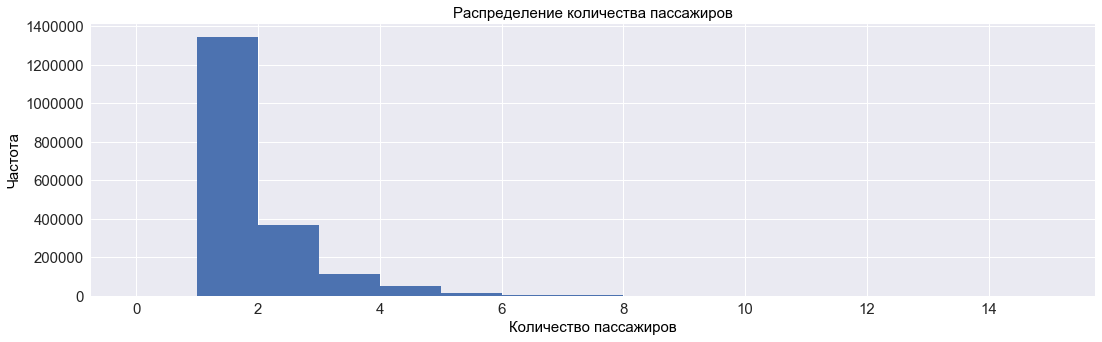

In [40]:
hist(df_all['Сегменты'], 16, 1, "Частота", "Количество пассажиров", "Распределение количества пассажиров")

**Комментарий:** *диаграмма boxplot показывает пять важных характеристик: `медиану`, `межквартильный размах`, `минимум` и `максимум`, `наличие выбросов`. По boxplot можно судить о `нормальности распределения` данных.
Подробней о boxplot по ссылке:
<a href="https://statanaliz.info/excel/diagrammy/diagramma-yashhik-s-usami-boxplot-v-excel-2016/">Диаграмма «ящик с усами» (boxplot)</a>*


<p align="center">

  <img width="500" height="450" src="https://www.statisticshowto.com/wp-content/uploads/2012/03/iqr.jpg">

</p>

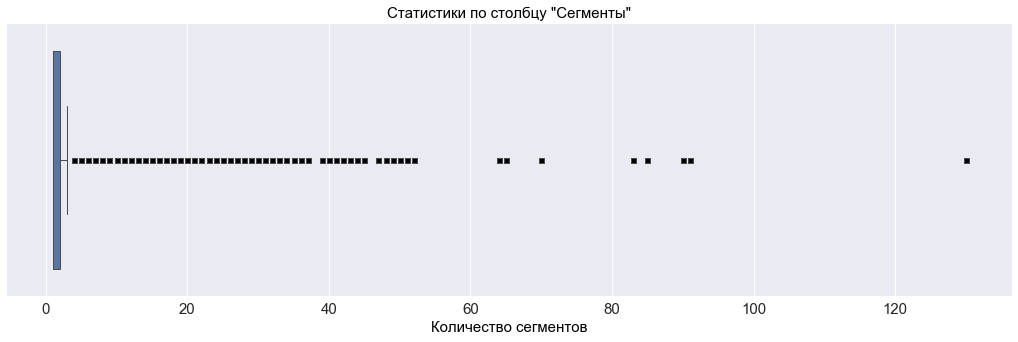

In [41]:
one_boxplot(df_all['Сегменты'], 'Статистики по столбцу "Сегменты"', 'Количество сегментов')

**Комментарий:** *столбец с количеством проданных сегментов содержит выбросы: точки за пределами максимального значения.*

In [42]:
print("Определим границу выбросов:")
outliers(df_all['Сегменты'])

Определим границу выбросов:
25-й квартиль: 1.0, 75-й квартиль: 2.0, IQR: 1.0, границы выбросов: [-0.5,3.5].


**Комментарий:** *в дальнейшем нам будет необходимо составить корреляционную матрицу, чтобы определить связь между признаками. Проведем очистку данных от выбросов, т.к. `коэффициент корреляции Пирсона не устойчив к ним.`
Границы [-0.5;8]. Верхняя граница установлена вручную (согласовано с продуктовыми менеджерами).
Подробней про слабые стороны коэффициета по ссылке:
<a href="https://statpsy.ru/pearson/linear-pirson/">Линейный коэффициент корреляции r-Пирсона</a>*

In [43]:
df_all=df_all.loc[df_all['Сегменты'].between(delete_outliers(df_all['Сегменты'])[0],8)]

Снова построим boxplot, чтобы посмотреть на результаты обработки данных. Остались значения от 1 до 8.


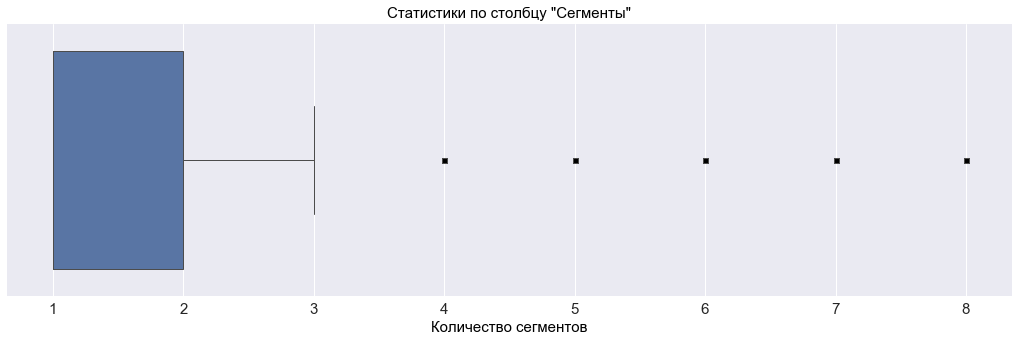

In [44]:
print("Снова построим boxplot, чтобы посмотреть на результаты обработки данных. Остались значения от 1 до 8.")
one_boxplot(df_all['Сегменты'], 'Статистики по столбцу "Сегменты"', 'Количество сегментов')

**Комментарий:** *после очистки данных в dataset остались брони с количеством пассажиров до 8 человек.*

#### 4.9.  Выручка за вычетом бонусов

In [45]:
description_column_count(df_all['Выручка'])

Длина столбца: 1900388
Количество значений "NaN": 0
Минимальное значение: 0.0
Максимальное значение: 593005.0


In [46]:
print("Количество строк с неопределенной ценой:",len(df_all[df_all['Выручка']==0]),
      "Что в процентом отношении составляет:", round(len(df_all[df_all['Выручка']==0]) / len(df_all) * 100, 2), "%")

Количество строк с неопределенной ценой: 2111 Что в процентом отношении составляет: 0.11 %


In [47]:
df_all = df_all[df_all['Выручка'] > 0]

**Комментарий:** *цена на билет зависит от бренда, класса бронирования, направления, наличия промо акций, поэтому проставить средние значения цены вместо пустых задача трудоемкая. Принято решение удалить 2111 строку, что составляет 0,11 %.*

In [48]:
# результаты обработки
description_column_count(df_all['Выручка'])

Длина столбца: 1898277
Количество значений "NaN": 0
Минимальное значение: 281.55
Максимальное значение: 593005.0


**Комментарий:** *минимальная цена в 300 руб. объясняется тем, что в dataset попадает информация по выручке за вычетом бонусов. Т.е первоначальная цена была 2000 руб., пассажир оплатил бонусами 1700 руб. и реальные деньги 300 руб.*

In [49]:
print("Построим гистограмму распределения выручки от пассажиров.")
print("Гистограмма урезана по оси х [0;40 000], чтобы было видно распределение. > 40 000 встречается реже.")

Построим гистограмму распределения выручки от пассажиров.
Гистограмма урезана по оси х [0;40 000], чтобы было видно распределение. > 40 000 встречается реже.


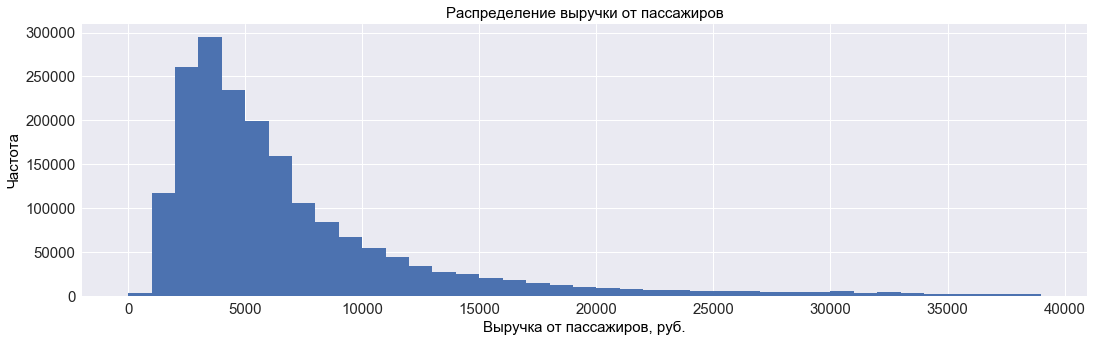

In [50]:
hist(df_all['Выручка'], 40000, 1000, "Частота", "Выручка от пассажиров, руб.", "Распределение выручки от пассажиров")

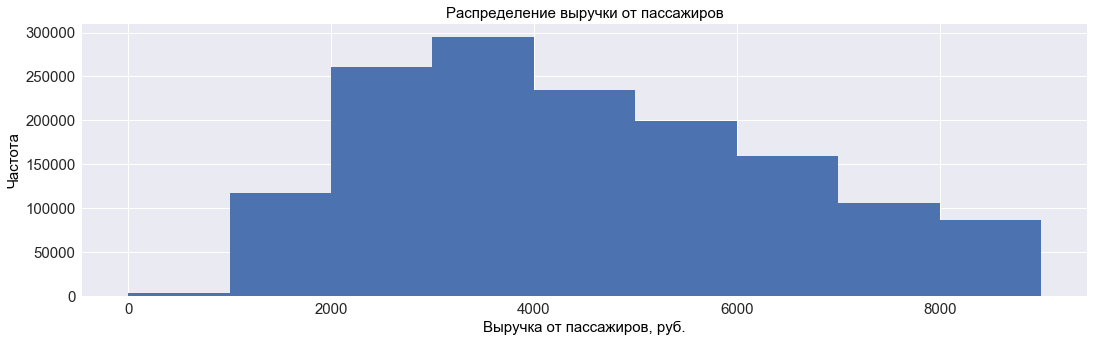

In [51]:
hist(df_all['Выручка'], 10000, 1000, "Частота", "Выручка от пассажиров, руб.", "Распределение выручки от пассажиров")

**Комментарий:** *от 2000 руб. до 7000 руб. - самая распространенная цена.*

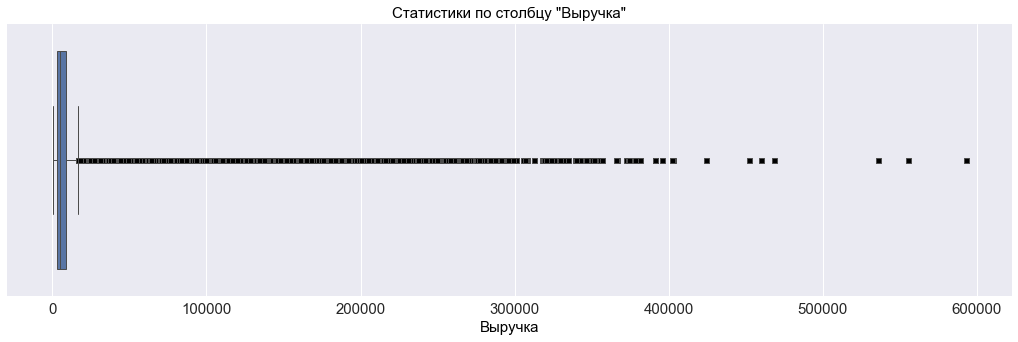

In [52]:
one_boxplot(df_all['Выручка'], 'Статистики по столбцу "Выручка"', 'Выручка')

**Комментарий:** *столбец с выручкой содержит выбросы: точки за пределами максимального значения.*

In [53]:
print("Определим границу выбросов:")
outliers(df_all['Выручка'])

Определим границу выбросов:
25-й квартиль: 3295.0, 75-й квартиль: 8530.0, IQR: 5235.0, границы выбросов: [-4557.5,16382.5].


**Комментарий:** *проведем очистку данных, установив врехнюю границу вручную.*

In [54]:
df_all=df_all.loc[df_all['Выручка'].between(delete_outliers(df_all['Выручка'])[0],20000)]

Снова построим boxplot, чтобы посмотреть на результаты обработки данных. Остались значения от 0 до 40000.


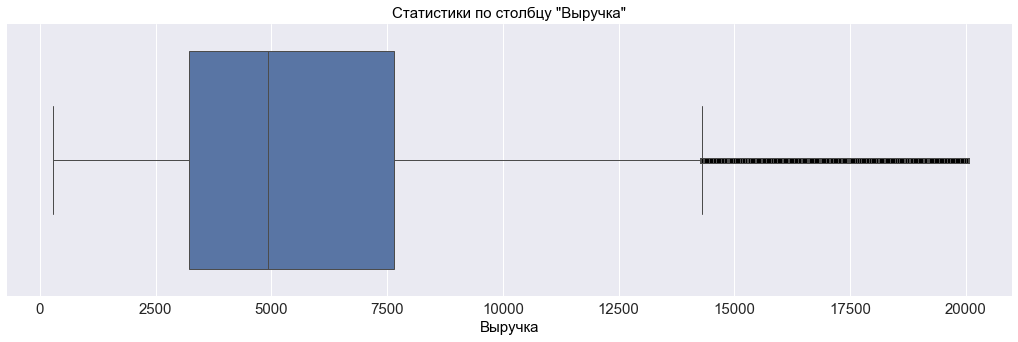

In [55]:
print("Снова построим boxplot, чтобы посмотреть на результаты обработки данных. Остались значения от 0 до 40000.")
one_boxplot(df_all['Выручка'], 'Статистики по столбцу "Выручка"', 'Выручка')

**Комментарий:** *после очистки данных в dataset остались брони с выручкой до 40000 руб.*

#### 4.10 Сегменты и выручка

In [56]:
print("Взрослые пассажиры")
description_column_count(df_all['Сегменты_взрослые'])
print()
description_column_count(df_all['Выручка_взрослые'])
print()
print("Дети")
description_column_count(df_all['Сегменты_дети'])
print()
description_column_count(df_all['Выручка_дети'])
print()
print("Младенцы")
description_column_count(df_all['Сегменты_младенцы'])
print()
description_column_count(df_all['Выручка_младенцы'])

Взрослые пассажиры
Длина столбца: 1784147
Количество значений "NaN": 17292
Минимальное значение: 1.0
Максимальное значение: 8.0

Длина столбца: 1784147
Количество значений "NaN": 17292
Минимальное значение: 281.55
Максимальное значение: 20000.0

Дети
Длина столбца: 1784147
Количество значений "NaN": 1611860
Минимальное значение: 1.0
Максимальное значение: 8.0

Длина столбца: 1784147
Количество значений "NaN": 1611860
Минимальное значение: 420.0
Максимальное значение: 19950.0

Младенцы
Длина столбца: 1784147
Количество значений "NaN": 1746490
Минимальное значение: 1.0
Максимальное значение: 3.0

Длина столбца: 1784147
Количество значений "NaN": 1746490
Минимальное значение: 0.0
Максимальное значение: 19580.0


**Комментарий:** *обработка не требуется. Минимальное значение выручки = 0 у младенцев объясняется тем, что они летат бесплатно. По ценам в 300 руб. комментарий выше.*

In [57]:
# т.к. улуг выбор места+ немного, объеденим
df_all['Количество_ВМ_итого']=df_all['Количество_ВМ']+df_all['Количество_ВМ+']
df_all['Выручка_ВМ_итого']=df_all['Выручка_ВМ']+df_all['Выручка_ВМ+']

#### 4.11. Количество_ВМ

In [58]:
description_column_count(df_all['Количество_ВМ_итого'])

Длина столбца: 1784147
Количество значений "NaN": 1300640
Минимальное значение: 0.0
Максимальное значение: 16.0


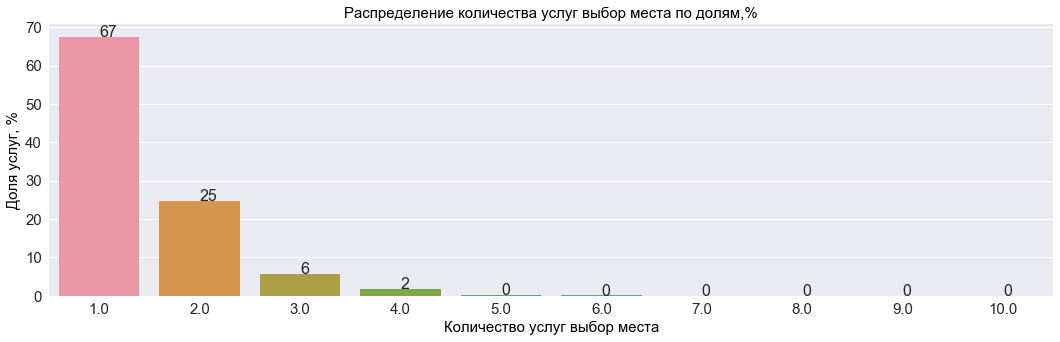

In [59]:
share(df_all[df_all['Количество_ВМ_итого']>0]['Количество_ВМ_итого'],"Количество услуг выбор места", "Доля услуг, %", 
      'Распределение количества услуг выбор места по долям,%')

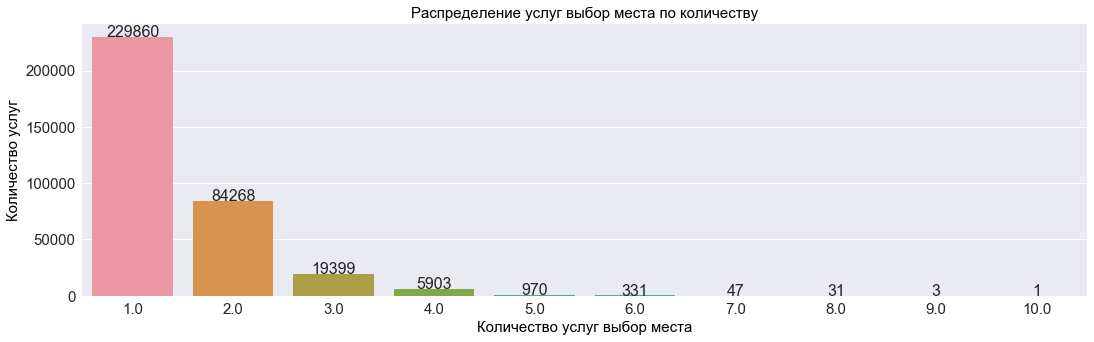

In [60]:
share_count(df_all[df_all['Количество_ВМ_итого']>0]['Количество_ВМ_итого'],"Количество услуг выбор места", "Количество услуг", 
      'Распределение услуг выбор места по количеству')

In [61]:
df_=pd.DataFrame(df_all[df_all['Количество_ВМ_итого']>0].groupby(['Сегменты'])['Количество_ВМ_итого'].value_counts(normalize=True)*100)

In [62]:
df_.columns=(['Частота встречаемости'])
freq=pd.pivot_table(df_, values=['Частота встречаемости'], index=['Сегменты'], 
               columns=['Количество_ВМ_итого'], aggfunc=np.sum, fill_value=0)
print("Таблица частоты (доля в %) покупки выбора места (столбцы) от количества сегментов (строки)")
freq

Таблица частоты (доля в %) покупки выбора места (столбцы) от количества сегментов (строки)


Частота встречаемости                              
Количество_ВМ_итого                    1  2  3  4  5  6  7  8  9  10 16
Сегменты                                                               
1                                      98  1  0  0  0  0  0  0  0  0  0
2                                       8 91  1  1  0  0  0  0  0  0  0
3                                       8 18 73  1  0  0  0  0  0  0  0
4                                       4  7 23 65  0  0  0  0  0  0  0
5                                       6  6  6 27 54  0  0  0  0  0  0
6                                       4 12  5  9 23 47  0  0  0  0  0
7                                       9 19  7  4  7 20 33  0  0  1  0
8                                       5 18  5  5  5  0 23 41  0  0  0

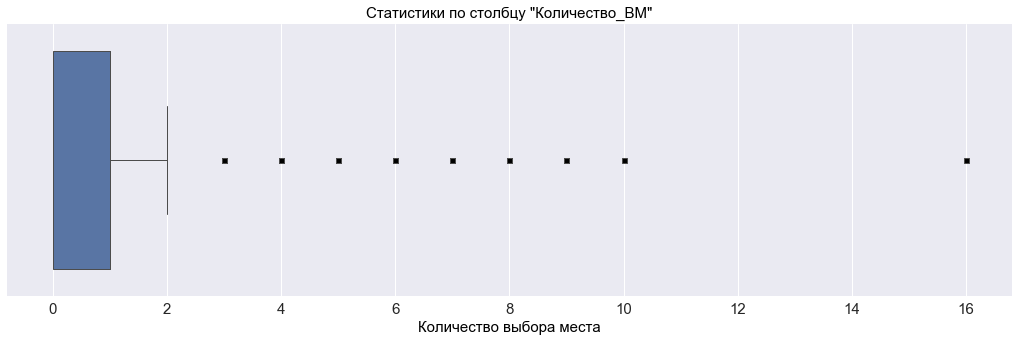

In [63]:
one_boxplot(df_all['Количество_ВМ_итого'], 'Статистики по столбцу "Количество_ВМ"', 'Количество выбора места')

In [64]:
print("Определим границу выбросов:")
outliers(df_all['Количество_ВМ_итого'])

Определим границу выбросов:
25-й квартиль: 0.0, 75-й квартиль: 1.0, IQR: 1.0, границы выбросов: [-1.5,2.5].


In [65]:
df_all=df_all.loc[df_all['Количество_ВМ_итого'].between(delete_outliers(df_all['Количество_ВМ_итого'])[0],5)]

Снова построим boxplot, чтобы посмотреть на результаты обработки данных. Остались значения от 0 до 5.


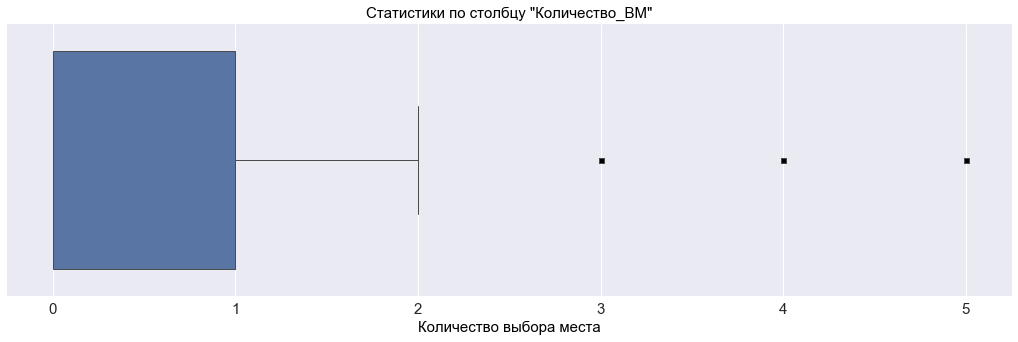

In [66]:
print("Снова построим boxplot, чтобы посмотреть на результаты обработки данных. Остались значения от 0 до 5.")
one_boxplot(df_all['Количество_ВМ_итого'], 'Статистики по столбцу "Количество_ВМ"', 'Количество выбора места')

**Комментарий:** *после очистки данных в dataset остались услуги Выбор места с количеством до 5 шт. в 1 броне*

#### 4.12. Выручка_ВМ

In [67]:
description_column_count(df_all['Выручка_ВМ_итого'])

Длина столбца: 483093
Количество значений "NaN": 0
Минимальное значение: 0.0
Максимальное значение: 12000.0


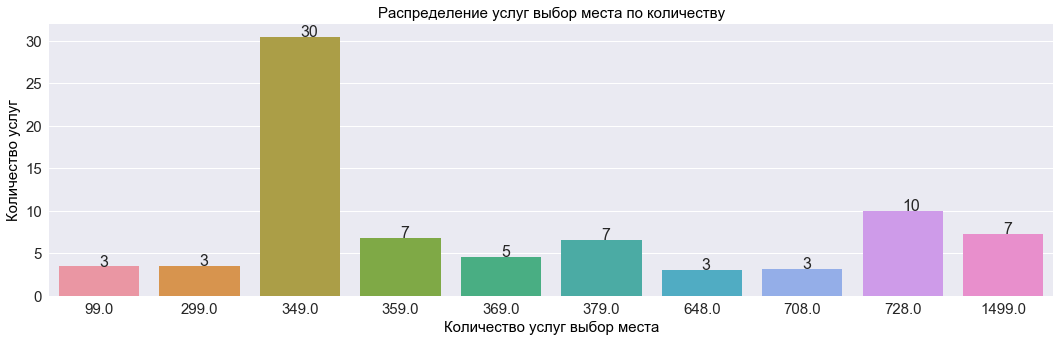

In [68]:
share(df_all[df_all['Выручка_ВМ_итого'] >0]['Выручка_ВМ_итого'],"Количество услуг выбор места", "Количество услуг", 
      'Распределение услуг выбор места по количеству')

In [69]:
print("Определим границу выбросов:")
outliers(df_all['Выручка_ВМ_итого'])

Определим границу выбросов:
25-й квартиль: 0.0, 75-й квартиль: 648.0, IQR: 648.0, границы выбросов: [-972.0,1620.0].


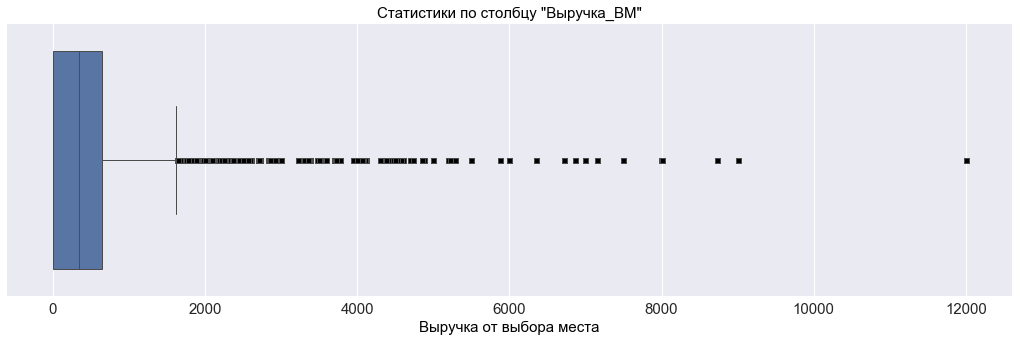

In [70]:
one_boxplot(df_all['Выручка_ВМ_итого'], 'Статистики по столбцу "Выручка_ВМ"', 'Выручка от выбора места')

In [71]:
df_all=df_all.loc[df_all['Выручка_ВМ_итого'].between(delete_outliers(df_all['Выручка_ВМ_итого'])[0],2000)]

Снова построим boxplot, чтобы посмотреть на результаты обработки данных. Остались значения от 0 до 2000.


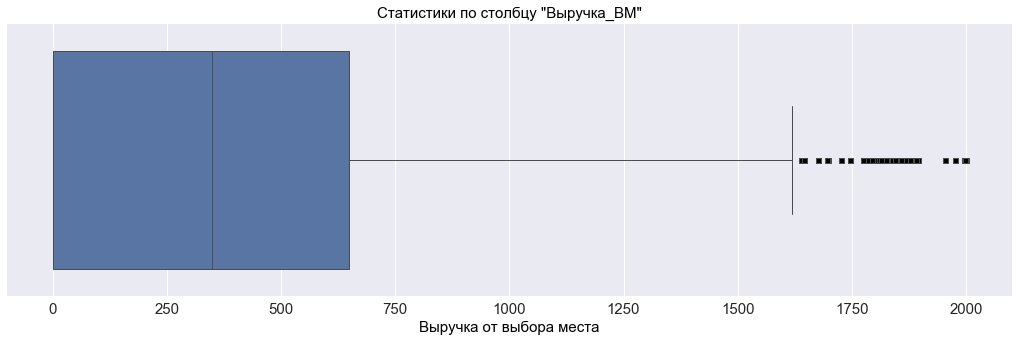

In [72]:
print("Снова построим boxplot, чтобы посмотреть на результаты обработки данных. Остались значения от 0 до 2000.")
one_boxplot(df_all['Выручка_ВМ_итого'], 'Статистики по столбцу "Выручка_ВМ"', 'Выручка от выбора места')

**Комментарий:** *после очистки данных в dataset остались услуги Выбор места с выручкой до 2000 руб. в 1 броне*

#### 4.13. Направление перевозки

In [73]:
description_column(df_all['Направление_перевозки'])

Количество уникальных значений в столбце: 2
Перечень уникальных значений: ['OW' 'RT']
Длина столбца: 473627
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 2


**Комментарий:** *обработка не требуется*

#### 4.14. Налет

In [74]:
description_column_count(df_all['Налет'])

Длина столбца: 473627
Количество значений "NaN": 0
Минимальное значение: 0.4102584615384615
Максимальное значение: 9.638889166666667


In [75]:
df_all[df_all['Налет']==df_all['Налет'].min()]['Маршрут'].unique()

array(['EZV-IRM'], dtype=object)

#### 4.15. Расстояние

In [76]:
description_column_count(df_all['Расстояние'])

Длина столбца: 473627
Количество значений "NaN": 0
Минимальное значение: 86.0
Максимальное значение: 7499.833333333332


In [77]:
df_all[df_all['Расстояние']==df_all['Расстояние'].min()]['Маршрут'].unique()

array(['EZV-IRM'], dtype=object)

**Комментарий:** *обработка не требуется. Расстояние между Березово и Игримом верное и составляет 86 км.*

#### 4.16. Направление

In [78]:
description_column(df_all['Направление'])

Количество уникальных значений в столбце: 3
Перечень уникальных значений: ['Региональные' 'Московские' 'Международные']
Длина столбца: 473627
Количество значений "NaN": 0
Количество значений, встретившихся в столбце более 10 раз: 3


**Комментарий:** *обработка не требуется*

#### 4.17. Добавление нового столбца

In [79]:
df_all['Наличие детей'] = np.where((df_all['Сегменты_дети']>0) | (df_all['Сегменты_младенцы']>0), 
                               "есть ребенок", "нет ребенка")
print(df_all['Наличие детей'].unique())
print(df_all[df_all['Наличие детей']=='есть ребенок']['Сегменты_дети'].unique())

['нет ребенка' 'есть ребенок']
[ 1.  2.  3. nan  4.  5.  7.]


In [80]:
df_all.head(3)

,Unnamed: 0,Дата транзакции,Дата вылета,PNR,Маршрут,Номер рейса,Канал,Сегменты_минимум,Сегменты_оптимум,Сегменты_премиум,Сегменты_бизнес,Сегменты_служебники,Сегменты_прочие,Сегменты,Выручка,Сегменты_взрослые,Выручка_взрослые,Сегменты_дети,Выручка_дети,Сегменты_младенцы,Выручка_младенцы,Количество_ВМ,Выручка_ВМ,Количество_ВМ+,Выручка_ВМ+,Направление_перевозки,Налет,Расстояние,Направление,Количество_ВМ_итого,Выручка_ВМ_итого,Наличие детей
0,0,2021-01-01,2021-01-01 06:05:00,8K8C6P,TJM-UFA,125,Оффлайн,0,1,0,0,0,0,1,4430,1,4430,nan,nan,nan,nan,1,349,0,0,OW,2,768,Региональные,1,349,нет ребенка
1,1,2021-01-01,2021-01-01 08:15:00,8K8CCS,AER-KRR,297,Оффлайн,1,0,0,0,0,0,1,1630,1,1630,nan,nan,nan,nan,1,349,0,0,OW,1,273,Региональные,1,349,нет ребенка
4,4,2021-01-01,2021-01-01 10:00:00,8K97N3,AAQ-VKO,459,Оффлайн,1,0,0,0,0,0,1,4930,1,4930,nan,nan,nan,nan,0,0,0,0,OW,2,1366,Московские,0,0,нет ребенка


In [81]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473627 entries, 0 to 516094
Data columns (total 32 columns):
Unnamed: 0               473627 non-null int64
Дата транзакции          473627 non-null object
Дата вылета              473627 non-null object
PNR                      473627 non-null object
Маршрут                  473627 non-null object
Номер рейса              473627 non-null int64
Канал                    473627 non-null object
Сегменты_минимум         473627 non-null float64
Сегменты_оптимум         473627 non-null float64
Сегменты_премиум         473627 non-null float64
Сегменты_бизнес          473627 non-null float64
Сегменты_служебники      473627 non-null float64
Сегменты_прочие          473627 non-null float64
Сегменты                 473627 non-null float64
Выручка                  473627 non-null float64
Сегменты_взрослые        469933 non-null float64
Выручка_взрослые         469933 non-null float64
Сегменты_дети            59954 non-null float64
Выручка_дети     

In [82]:
df_all.describe()

,Unnamed: 0,Номер рейса,Сегменты_минимум,Сегменты_оптимум,Сегменты_премиум,Сегменты_бизнес,Сегменты_служебники,Сегменты_прочие,Сегменты,Выручка,Сегменты_взрослые,Выручка_взрослые,Сегменты_дети,Выручка_дети,Сегменты_младенцы,Выручка_младенцы,Количество_ВМ,Выручка_ВМ,Количество_ВМ+,Выручка_ВМ+,Налет,Расстояние,Количество_ВМ_итого,Выручка_ВМ_итого
count,473627,473627,473627,473627,473627,473627,473627,473627,473627,473627,469933,469933,59954,59954,13050,13050,473627,473627,473627,473627,473627,473627,473627,473627
mean,203493,439,1,0,0,0,0,0,1,6709,1,6188,1,4459,1,159,1,297,0,92,3,1498,1,388
std,128806,589,1,1,0,0,0,0,1,4043,1,3601,0,2311,0,880,1,322,0,347,1,707,1,413
min,0,101,0,0,0,0,0,0,1,494,1,494,1,420,1,0,0,0,0,0,0,86,0,0
25%,96292,274,0,0,0,0,0,0,1,3674,1,3485,1,2835,1,0,0,0,0,0,2,1116,0,0
50%,192364,378,1,0,0,0,0,0,1,5585,1,5285,1,3940,1,0,1,349,0,0,2,1445,1,349
75%,291528,523,1,1,0,0,0,0,2,8685,2,7885,1,5530,1,0,1,379,0,0,3,1751,1,648
max,520702,9880,8,8,4,1,0,5,8,20000,8,20000,7,19930,2,18655,5,2000,4,1999,10,7500,5,2000


**Вывод:** *проведена обработка dataset, в результате которой обработаны нулевые значения, удалены выбросы. Итоговый dataset имеет 32 столбца и 493075 строк.*

### 5. Корреляционный анализ, формирование гипотез

*На основе имеющихся данных необходимо определить, какие факторы влияют на покупку услуги "Выбор места".*

In [83]:
new=pd.DataFrame(df_all.pivot_table(values = ['Сегменты'], index = ['Дата транзакции'], columns=['Канал'], 
                   aggfunc = sum).to_records())
new['Доля онлайн'] = (new["('Сегменты', 'Онлайн')"] / (new["('Сегменты', 'Онлайн')"] + new["('Сегменты', 'Оффлайн')"])) * 100
new['Доля оффлайн'] = (new["('Сегменты', 'Оффлайн')"] / (new["('Сегменты', 'Онлайн')"] + new["('Сегменты', 'Оффлайн')"])) * 100

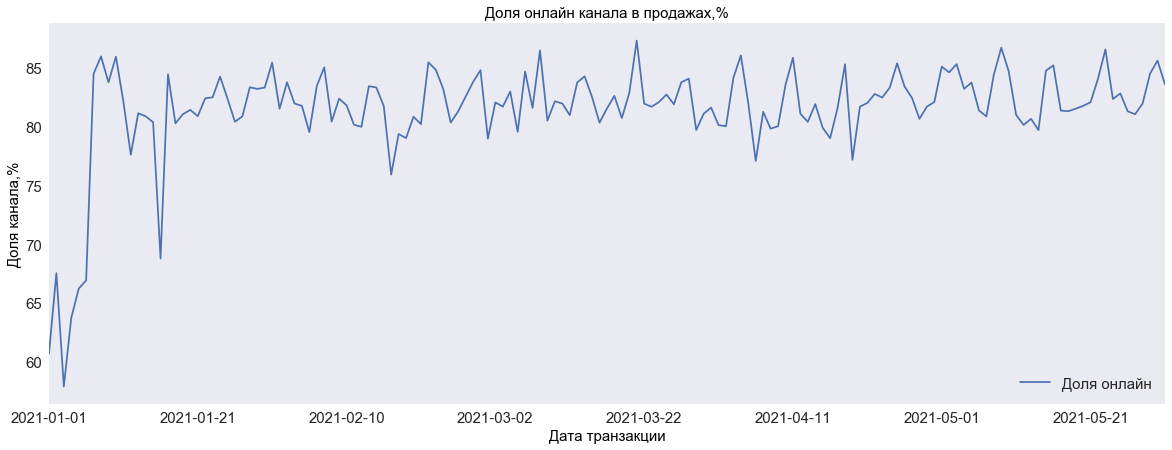

In [84]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20,7)
pd.DataFrame(new[['Дата транзакции','Доля онлайн']]).set_index('Дата транзакции').plot(kind = 'line', stacked=True)
plt.xlabel('Дата транзакции', fontsize=15, color='black')
plt.ylabel('Доля канала,%', fontsize=15, color='black')
plt.title('Доля онлайн канала в продажах,%', fontsize=15, color='black')
plt.tick_params(axis='both', labelsize=15)
plt.legend(loc='lower right', facecolor='black', fontsize=15)
plt.grid(False)
plt.show()

**Комментарий:** **85% билетов** *приобретается пассажиром в онлайн канале.*

In [85]:
new_=pd.DataFrame(df_all.pivot_table(values = ['Количество_ВМ_итого'], index = ['Дата транзакции'], columns=['Канал'], 
                   aggfunc = sum).to_records())
new_['Доля онлайн'] = (new_["('Количество_ВМ_итого', 'Онлайн')"] / (new_["('Количество_ВМ_итого', 'Онлайн')"] + 
                                                                  new_["('Количество_ВМ_итого', 'Оффлайн')"])) * 100
new_['Доля оффлайн'] = (new_["('Количество_ВМ_итого', 'Оффлайн')"] / (new_["('Количество_ВМ_итого', 'Онлайн')"] + 
                                                                    new_["('Количество_ВМ_итого', 'Оффлайн')"])) * 100

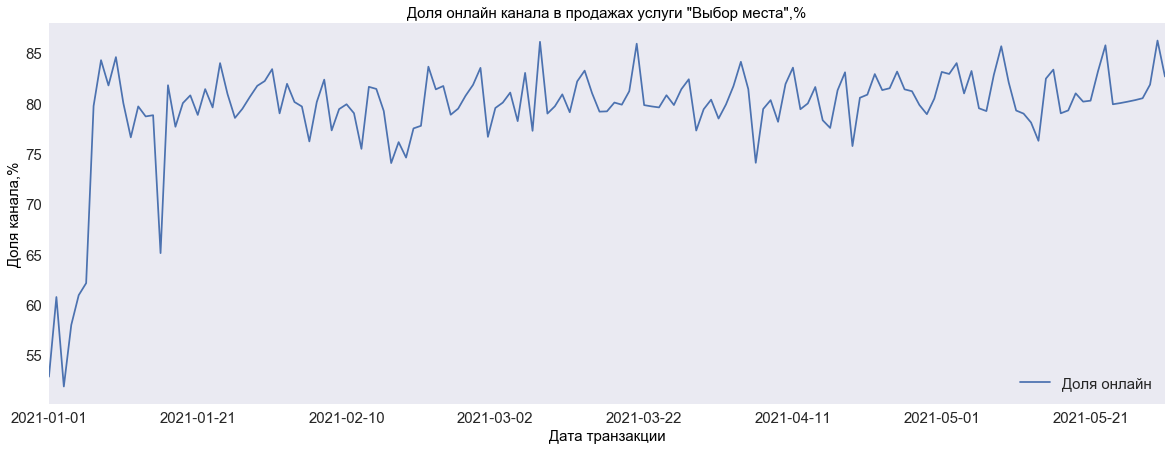

In [86]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20,7)
pd.DataFrame(new_[['Дата транзакции','Доля онлайн']]).set_index('Дата транзакции').plot(kind = 'line', stacked=True)
plt.xlabel('Дата транзакции', fontsize=15, color='black')
plt.ylabel('Доля канала,%', fontsize=15, color='black')
plt.title('Доля онлайн канала в продажах услуги "Выбор места",%', fontsize=15, color='black')
plt.tick_params(axis='both', labelsize=15)
plt.legend(loc='lower right', facecolor='black', fontsize=15)
plt.grid(False)
plt.show()

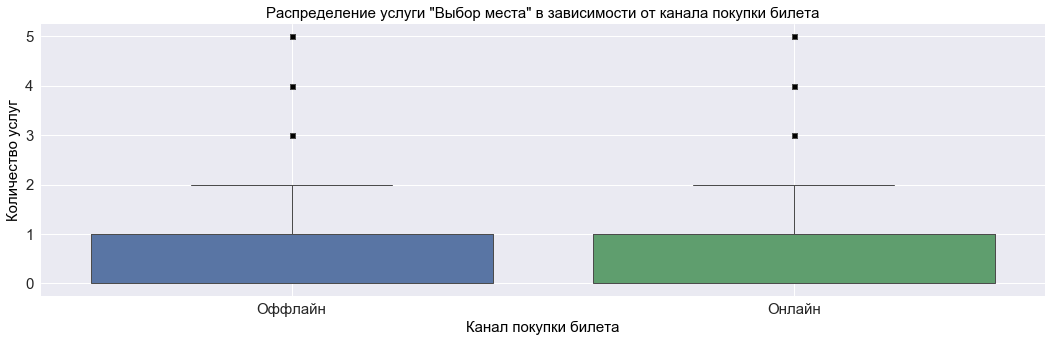

In [87]:
boxplot(df_all['Канал'],df_all['Количество_ВМ_итого'],df_all,
        'Распределение услуги "Выбор места" в зависимости от канала покупки билета','Канал покупки билета',
        'Количество услуг')

**Комментарий:** **85%** *услуг Выбор места приобретаются пассажиром в онлайн канале. При этом в обоих каналах приобретается 0-1, максимум 2 услуги.*

#### 5.1. Корреляционная матрица

`Коэффициент корреляции Пирсона` – мера линейной связи  между двумя интервальными или характеризующими отношения переменными. Наличие высокой корреляции между переменными не может свидетельствовать о причинно-следственной связи: она может быть подтверждена или опровергнута только с помощью постановки эксперимента. 

`Расчет коэффициента корреляции Пирсона.`

Для генеральной совокупности – p, для выборки – r. 

Принимает значение в интервале от (-1,1). 

Тип шкалы – метрическая.
Чтобы приступать к расчетам коэффициента корреляции r-Пирсона необходимо выполнение следующих условий:
1. исследуемые переменные X и Y должны быть распределены нормально;
2. исследуемые переменные X и Y должны быть измерены в интервальной шкале или шкале отношений;
3. количество значений в исследуемых переменных X и Y должно быть одинаковым.

`Слабыми сторонами линейного коэффициента корреляции Пирсона являются`:
1. неустойчивость к выбросам;
2. с помощью коэффициента корреляции Пирсона можно определить только силу линейной взаимосвязи между переменными, другие виды взаимосвязей выявляются методами регрессионного анализа.

In [88]:
df_corr=df_all[['PNR', 'Сегменты_минимум', 'Сегменты_оптимум', 'Сегменты_премиум', 'Сегменты_бизнес', 'Сегменты_прочие', 
        'Сегменты', 'Сегменты_взрослые','Сегменты_дети', 'Сегменты_младенцы','Налет', 'Расстояние', 
                'Количество_ВМ_итого', 'Выручка_ВМ_итого'
       ]].groupby(by=['PNR']).sum()

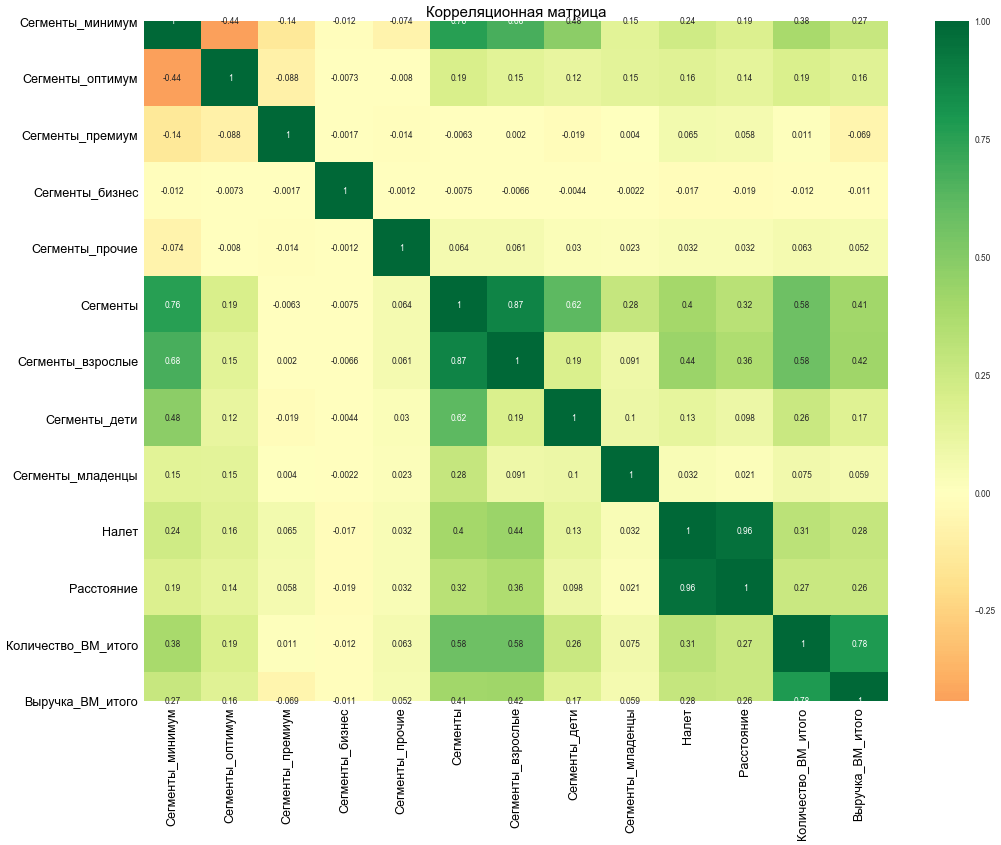

In [89]:
plt.style.use('seaborn')
plt.figure(figsize=(20,15), dpi= 60)
sns.heatmap(df_corr.corr(), xticklabels=df_corr.corr().columns, yticklabels=df_corr.corr().columns, cmap='RdYlGn', 
            center=0, annot=True, fmt='.2g')
plt.title('Корреляционная матрица', fontsize=18, color='black')
plt.xticks(fontsize=15, color='black')
plt.yticks(fontsize=15, color='black')
plt.tick_params(axis='both', labelsize=15)
plt.show()

**Комментарий:** *количество услуг "Выбор места" коррелирует со следующими столбцами:*
* 0.38 количество пассажиров, купивших Minimum (Minimum покупают услугу "Выбор места" чаще);
* 0.19 количество пассажиров, купивших Optimum (Optimum покупают услугу "Выбор места" чаще);
* -0.014 количество пассажиров, купивших Premium (корреляция отрицательная, т.к. в Premium включена услуга "Выбор места");
* -0.012 количество пассажиров, купивших Business (корреляция отрицательная, т.к. в Business включена услуга "Выбор места");
* 0.57 количество пассажиров (чем больше пассажиров в 1 броне, тем больше услуг покупают);
* 0.26 количество детей (чем больше детей в 1 броне, тем больше услуг покупают);
* 0.26 расстояние (чем больше расстояние, тем больше услуг покупают);
* 0.31 налет (чем больше налет, тем больше услуг покупают);

#### 5.2. Подробный корреляционный анализ

__Зависит ли покупка услуги от количества пассажиров в броне?__

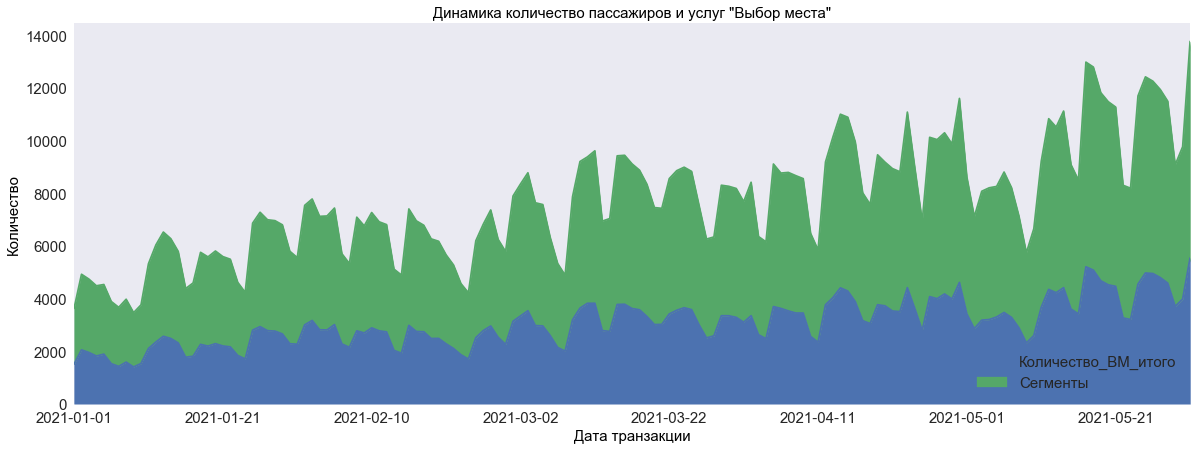

In [90]:
bar_pivot_table('Сегменты','Количество_ВМ_итого','Дата транзакции',sum,'Динамика количество пассажиров и услуг "Выбор места"',
                'Дата транзакции','Количество')

**Комментарий:** *исходя из динамики количества пассажиров и количества услуг "Выбор места" в одной броне, можно предположить, что **покупка услуги зависит от количества человек в броне**, т.к. динамика схожая. Проверим предположение построив диаграмму boxplot.*

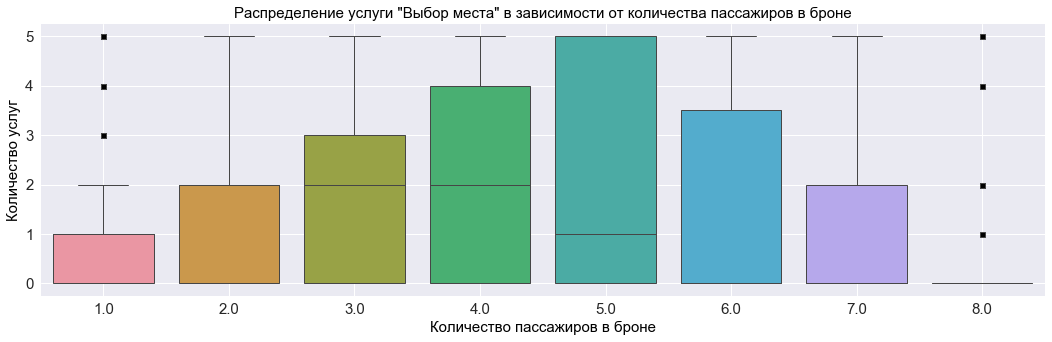

In [91]:
boxplot(df_all['Сегменты'],df_all['Количество_ВМ_итого'],df_all,
        'Распределение услуги "Выбор места" в зависимости от количества пассажиров в броне','Количество пассажиров в броне',
        'Количество услуг')

**Комментарий** *диаграмма boxplot подтверждает зависимость между покупкой услуги и количеством человек в броне, однако связь ломается в случае, когда в броне больше 5 пассажиров.*

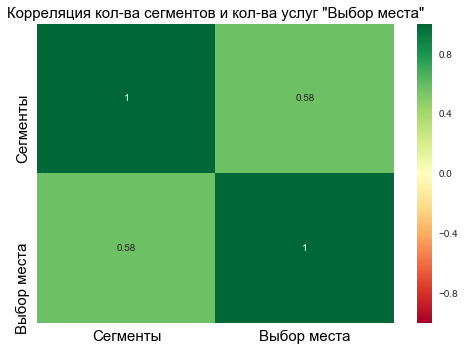

In [92]:
correlation_vis('Сегменты','Количество_ВМ_итого','Корреляция кол-ва сегментов и кол-ва услуг "Выбор места"',
            'Сегменты','Выбор места')

**Комментарий** *коэффициент корреляции 0.58%, что соответствует средней тесноте связи. Подробней о силе связи по ссылке:
<a href="https://statpsy.ru/correlation/velicina/">сила корреляционной связи</a>*

__Зависит ли покупка услуги от бренда?__

In [93]:
df_all['Наличие минимума'] = np.where(df_all['Сегменты_минимум']>0, "минимум", '')
df_all['Наличие оптимума'] = np.where(df_all['Сегменты_оптимум']>0, "оптимум", '')
df_all['Наличие премиума'] = np.where(df_all['Сегменты_премиум']>0, "премиум", '')
df_all['Наличие бизнеса'] = np.where(df_all['Сегменты_бизнес']>0, "бизнес", '')
df_all['Наличие служебников'] = np.where(df_all['Сегменты_служебники']>0, "служебники", '')
df_all['Наличие прочих'] = np.where(df_all['Сегменты_прочие']>0, "прочие", '')
df_all['Бренды'] = df_all[['Наличие минимума','Наличие оптимума','Наличие премиума',
                           'Наличие бизнеса','Наличие служебников','Наличие прочих']].astype(str).sum(1)

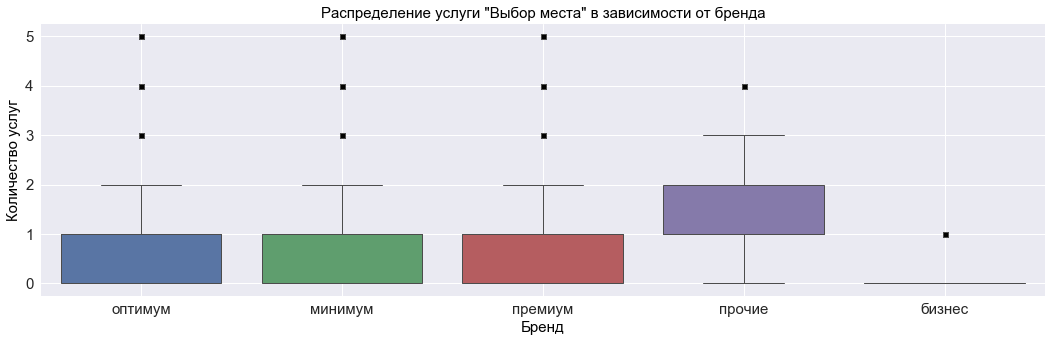

In [94]:
boxplot(df_all['Бренды'],df_all['Количество_ВМ_итого'],df_all,
        'Распределение услуги "Выбор места" в зависимости от бренда','Бренд','Количество услуг')

**Комментарий** *пассажиры с билетами брендов оптимум, минимум, премиум преобретают 0-1 услугу, максимум 2. Прочие продажи это продажи иностранных компаний на рейсы UT. Пассажиры, которые  купили билеты у других компаний на рейсы UT покупают 1-2 услуги, максимум 3. Можно сделать предположение, что качество клиентов у иностранных компаний выше, т.е. клиенты более лояльны к покупке дополнительной услуги.*

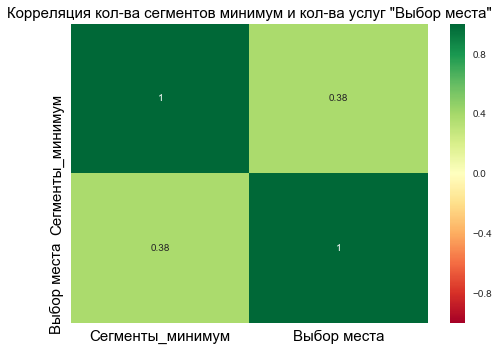

In [95]:
correlation_vis('Сегменты_минимум','Количество_ВМ_итого','Корреляция кол-ва сегментов минимум и кол-ва услуг "Выбор места"',
            'Сегменты_минимум','Выбор места')

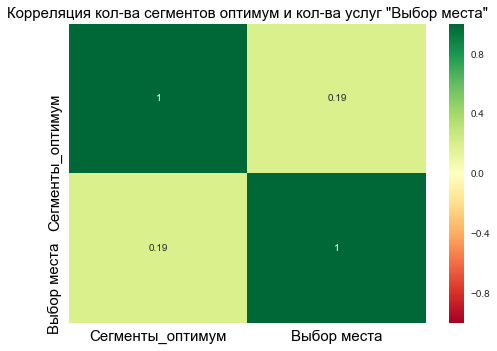

In [96]:
correlation_vis('Сегменты_оптимум','Количество_ВМ_итого','Корреляция кол-ва сегментов оптимум и кол-ва услуг "Выбор места"',
            'Сегменты_оптимум','Выбор места')

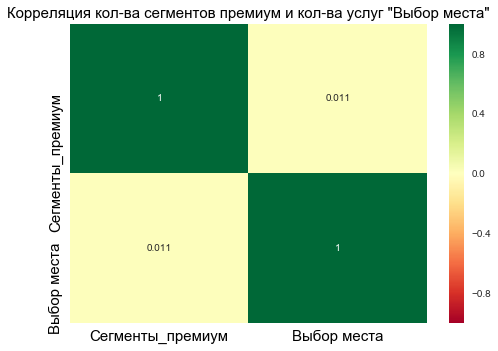

In [97]:
correlation_vis('Сегменты_премиум','Количество_ВМ_итого','Корреляция кол-ва сегментов премиум и кол-ва услуг "Выбор места"',
            'Сегменты_премиум','Выбор места')

**Комментарий** *высокая корреляция услуги Выбор места у бренда минимум и оптимум, т.к. данная услуга не включена в пакет.*

__Зависит ли покупка услуги от наличие ребенка в броне?__

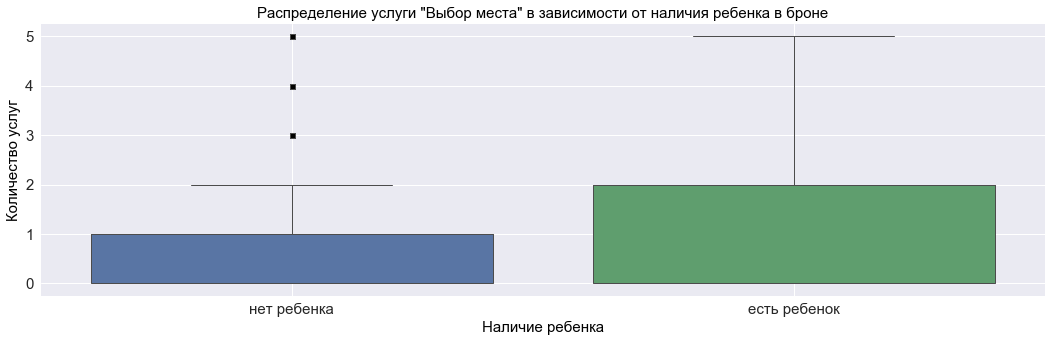

In [98]:
boxplot(df_all['Наличие детей'],df_all['Количество_ВМ_итого'],df_all,
        'Распределение услуги "Выбор места" в зависимости от наличия ребенка в броне','Наличие ребенка','Количество услуг')

**Комментарий** *если пассажир летит с ребенком, то в среднем он покупает 2 услуги.*

__Зависит ли покупка услуги от направления и типа маршрута?__

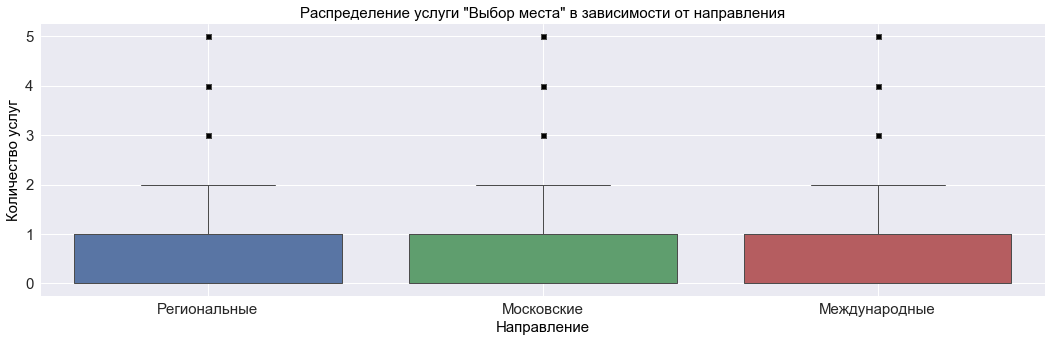

In [99]:
boxplot(df_all['Направление'],df_all['Количество_ВМ_итого'],df_all,
        'Распределение услуги "Выбор места" в зависимости от направления','Направление', 'Количество услуг')

In [100]:
rout_group=df_all.pivot_table(values = ['Сегменты', 'Количество_ВМ_итого'], index = ['Направление'], aggfunc = sum)
rout_group['Пенетрация']=rout_group['Количество_ВМ_итого']/rout_group['Сегменты']*100

In [101]:
rout_group['Количество_ВМ_итого'].sum()

464245.0

In [102]:
rout_group['Сегменты'].sum()

697108.0

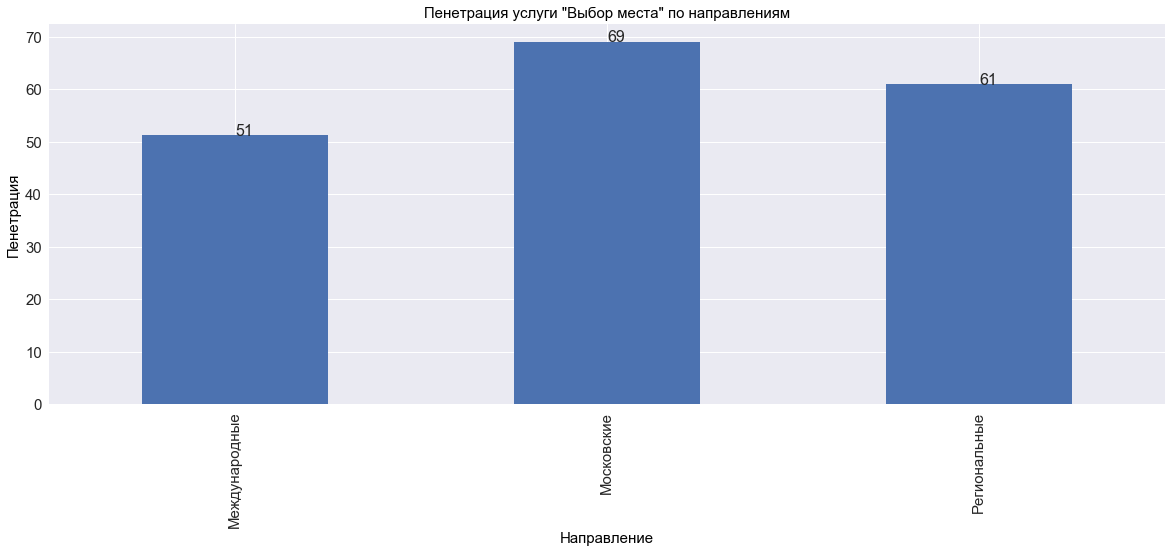

In [103]:
penet('Сегменты', 'Количество_ВМ_итого', 'Направление', 'Пенетрация', 'Пенетрация услуги "Выбор места" по направлениям' )

**Комментарий** *на московских направлениях пенетрация услуги "Выбор места" выше. (Внимание! Данные очищенные!)*

__Зависит ли покупка услуги от типа направления?__

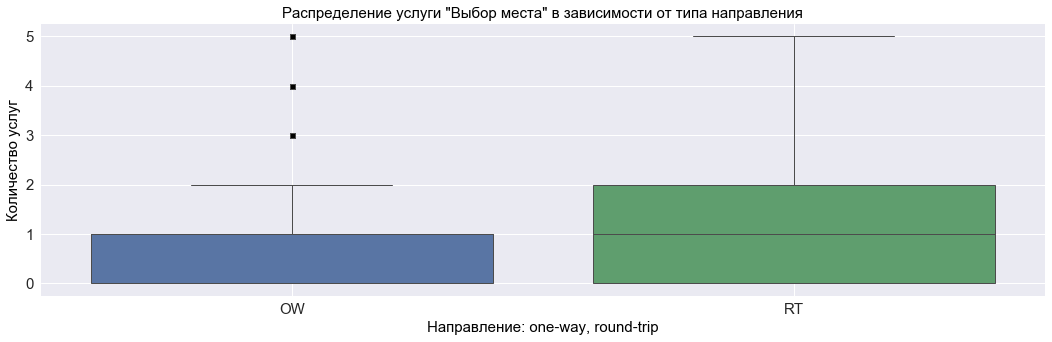

In [104]:
boxplot(df_all['Направление_перевозки'],df_all['Количество_ВМ_итого'],df_all,
        'Распределение услуги "Выбор места" в зависимости от типа направления','Направление: one-way, round-trip',
        'Количество услуг')

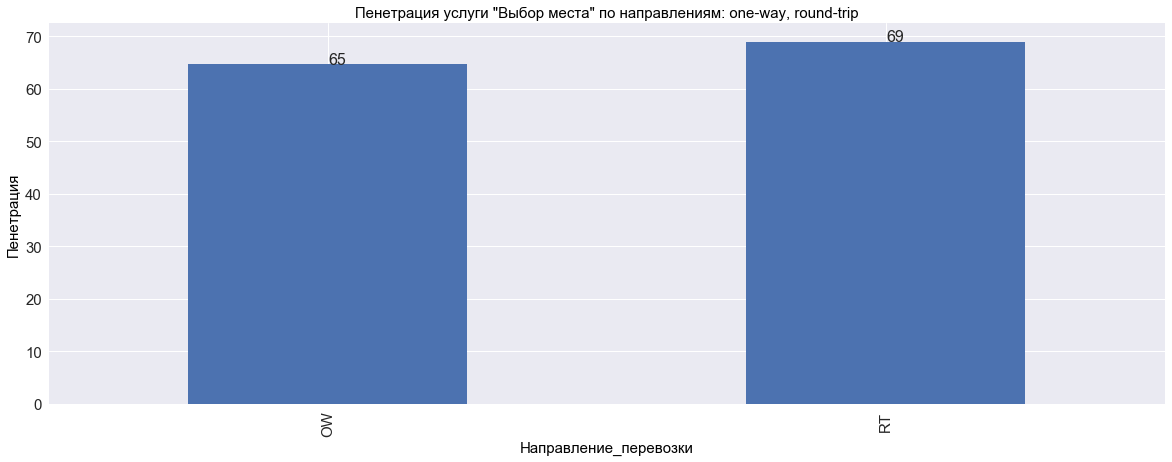

In [105]:
penet('Сегменты', 'Количество_ВМ_итого', 'Направление_перевозки', 'Пенетрация', 
      'Пенетрация услуги "Выбор места" по направлениям: one-way, round-trip')

**Комментарий** *если пассажир летит туда-обратно, то он чаще приобретает услугу Выбор места.*

__Зависит ли покупка услуги от расстояния?__

In [106]:
print("Минимальное расстояние:", df_all['Расстояние'].min())
print("Максимальное расстояние:", round(df_all['Расстояние'].max(),1))

Минимальное расстояние: 86.0
Максимальное расстояние: 7499.8


In [107]:
df_all['Расстояние_признак'] = np.where(df_all['Расстояние'].astype(int)<=1000, "до 1000 км", 
                                        np.where( (df_all['Расстояние'].astype(int)>=1001) & (df_all['Расстояние'].astype(int)<=2000), "до 2000 км", 
                                        np.where( (df_all['Расстояние'].astype(int)>=2001) & (df_all['Расстояние'].astype(int)<=3000), "до 3000 км",
                                        np.where( (df_all['Расстояние'].astype(int)>=3001) & (df_all['Расстояние'].astype(int)<=4000), "до 4000 км",
                                        np.where( (df_all['Расстояние'].astype(int)>=4001) & (df_all['Расстояние'].astype(int)<=5000), "до 5000 км",
                                        np.where( (df_all['Расстояние'].astype(int)>=5001) & (df_all['Расстояние'].astype(int)<=6000), "до 6000 км",
                                        np.where( (df_all['Расстояние'].astype(int)>=6001) & (df_all['Расстояние'].astype(int)<=7000), "до 7000 км",
                                        np.where( (df_all['Расстояние'].astype(int)>=7001) & (df_all['Расстояние'].astype(int)<=10000), "выше 7000 км", ""
                                       ))))))))

In [108]:
df_all['Расстояние_признак'].unique()

array(['до 1000 км', 'до 2000 км', 'до 3000 км', 'до 4000 км',
       'до 7000 км', 'выше 7000 км'], dtype=object)

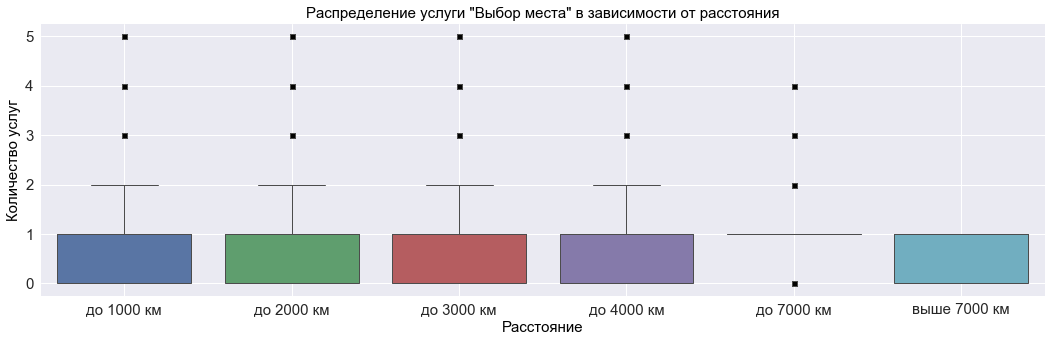

In [109]:
boxplot(df_all['Расстояние_признак'],df_all['Количество_ВМ_итого'],df_all,
        'Распределение услуги "Выбор места" в зависимости от расстояния','Расстояние','Количество услуг')

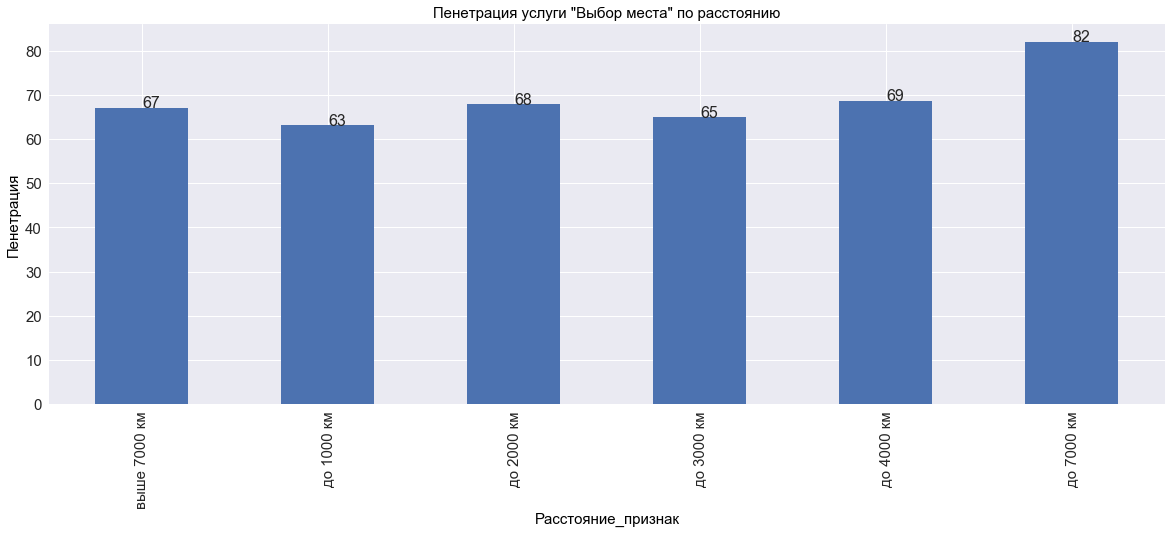

In [110]:
penet('Сегменты', 'Количество_ВМ_итого', 'Расстояние_признак', 'Пенетрация', 
      'Пенетрация услуги "Выбор места" по расстоянию')

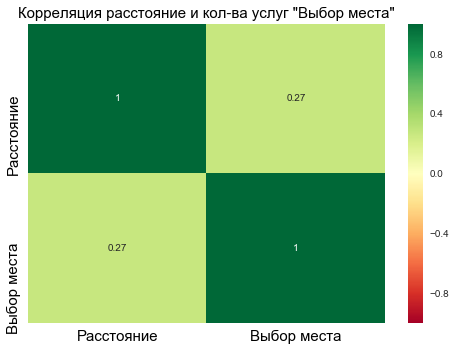

In [111]:
correlation_vis('Расстояние','Количество_ВМ_итого','Корреляция расстояние и кол-ва услуг "Выбор места"',
            'Расстояние','Выбор места')

**Комментарий** *пенетрация услуги Выбор места выше, чем больше расстояние.*

__Зависит ли покупка услуги от налета?__

In [112]:
print("Минимальный налет:", round(df_all['Налет'].min(),3))
print("Максимальный налет:", round(df_all['Налет'].max(),3))

Минимальный налет: 0.41
Максимальный налет: 9.639


In [113]:
df_all['Налет_признак'] = np.where(df_all['Налет'].astype(int)<=1, "до 1 часа", 
                                        np.where( (df_all['Налет'].astype(int)>=1) & (df_all['Налет'].astype(int)<=2), "до 2 часов", 
                                        np.where( (df_all['Налет'].astype(int)>=1.001) & (df_all['Налет'].astype(int)<=3), "до 3 часов",
                                        np.where( (df_all['Налет'].astype(int)>=3.001) & (df_all['Налет'].astype(int)<=4), "до 4 часов",
                                        np.where( (df_all['Налет'].astype(int)>=4.001) & (df_all['Налет'].astype(int)<=5), "до 5 часов",
                                        np.where( (df_all['Налет'].astype(int)>=5.001) & (df_all['Налет'].astype(int)<=6), "до 6 часов",
                                        np.where( (df_all['Налет'].astype(int)>=6.001) & (df_all['Налет'].astype(int)<=7), "до 7 часов",
                                        np.where( (df_all['Налет'].astype(int)>=7.001) & (df_all['Налет'].astype(int)<=8), "до 8 часов",
                                        np.where( (df_all['Налет'].astype(int)>=8.001) & (df_all['Налет'].astype(int)<=15), "выше 8 часов", ""
                                       )))))))))

In [114]:
df_all['Налет_признак'].unique()

array(['до 2 часов', 'до 1 часа', 'до 3 часов', 'до 4 часов',
       'до 5 часов', 'до 8 часов', 'выше 8 часов'], dtype=object)

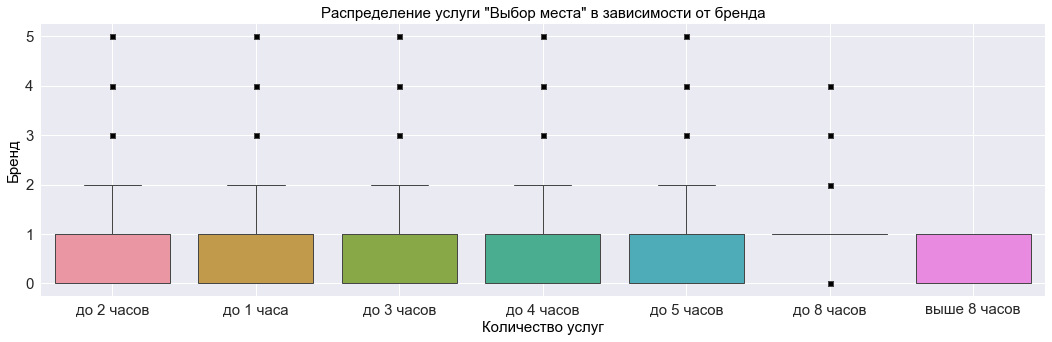

In [115]:
boxplot(df_all['Налет_признак'],df_all['Количество_ВМ_итого'],df_all,
        'Распределение услуги "Выбор места" в зависимости от бренда','Количество услуг',
        'Бренд')

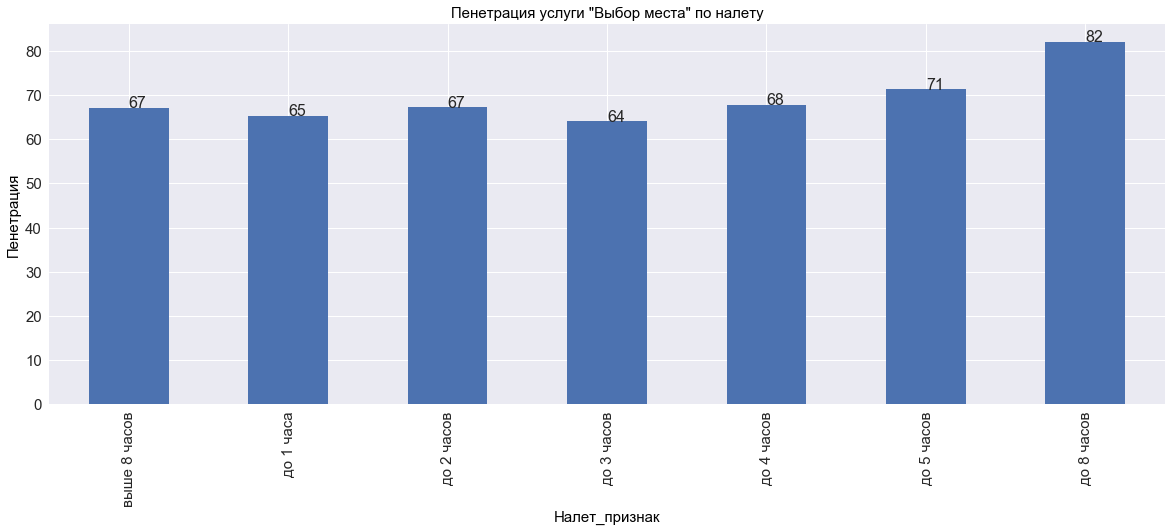

In [116]:
penet('Сегменты', 'Количество_ВМ_итого', 'Налет_признак', 'Пенетрация', 
      'Пенетрация услуги "Выбор места" по налету')

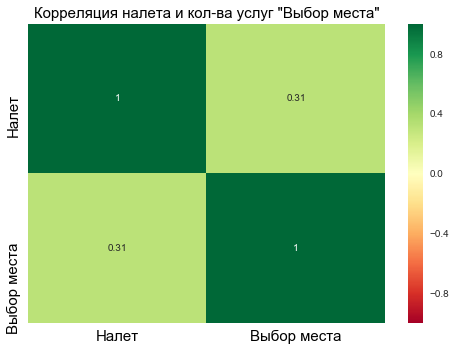

In [117]:
correlation_vis('Налет','Количество_ВМ_итого','Корреляция налета и кол-ва услуг "Выбор места"',
            'Налет','Выбор места')

**Комментарий** *пенетрация услуги Выбор места выше, чем больше налет.*

### 6. Результаты

Проведя анализ продаж услуги "Выбор места" мы пришли к следующим выводам:

1. покупка услуги "Выбор места" зависит от количества человек в броне (коэффициент корреляции - 0,58%): чем больше человек в одной броне, тем выше вероятность покупки услуги. Однако связь "ломается", когда в броне больше 5 пассажиров. Вероятно это связано с тем, что большой группой летают вахтовики, командировочники, группы школьников и т.д.

2. пассажир, купивший билет бренда minimum, optimum покупает услугу чаще (коэффициент корреляции - 0,38% , 0,19% соответственно), т.к. она не входит в пакет. Важно отменить, что если  прочие компании продают на рейсы UT 1-2 услуги, то UT продает на свои рейсы 0-1 услугу, что свидетельствует о "качестве" пассажиров других АК и их большей лояльности к покупке дополнительной услуги. 

3. если в броне есть ребенок, высока вероятность приобретения услуги "Выбор места";

4. чаще всего услугу покупают на московских направлениях (1 место), региональных (2 место), международных (3 место).

5. если пассажир летит туда-обратно, то высокая вероятность покупки услуги;

6. чем выше расстояние и налет, тем больше услуг покупают.